# Urban Heat Island Analysis

#### Importing libraries and setting column width

In [164]:
# Control downloading new location data from the internet
GET_NEW_LOCATION = False

In [165]:
import os
import json
import requests
import pandas as pd
import numpy as np
from langchain_openai import ChatOpenAI #, JsonOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from pydantic import BaseModel, Field, create_model
from typing import List, Optional, Text, Dict
from pprint import pprint
from IPython.display import display, Markdown
import plotly.express as px
import plotly.graph_objects as go
import xarray as xr
import geopandas as gpd
from shapely.geometry import Point, box
import fiona
import matplotlib.pyplot as plt
import seaborn as sns
import missingno


In [166]:

import matplotlib
matplotlib.__version__

'3.8.4'

In [167]:
missingno.__version__

'0.5.2'

In [168]:
# importing James custom functions
%load_ext autoreload
%autoreload 2
import os, sys
# sys.path.append(os.path.abspath("../"))
import custom_functions as cf
dir(cf.xml)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


['ET',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'clean_xml_dict',
 'extract_coordinates',
 'label_coordinates',
 'parse_and_clean_xml_file',
 'pd',
 'preview_xml_dict',
 'xml_to_dict']

In [169]:
pd.set_option('display.max_colwidth', 250)

### Grabbing Open AI key

In [170]:
# # our OpenAI token
# # creds_file_open_ai = r"c:/Users/Chris/.secret/open_ai.txt"
# with open(creds_file_open_ai) as f:
#     creds_open_ai = f.read()

# os.environ['OPENAI_API_KEY'] = creds_open_ai

You can access MODIS LST data through various APIs provided by NASA and other institutions. One of the most commonly used APIs is the **NASA Earthdata Search API**. Additionally, you can use the `pyproj` and `sentinelsat` libraries to access and download MODIS data.

### Accessing MODIS LST Data via NASA Earthdata API

To use the NASA Earthdata API, you will need to:

1. **Register for a NASA Earthdata Account:**
   - You need an Earthdata account to access the data. You can register at [Earthdata Login](https://urs.earthdata.nasa.gov/users/new).

2. **Use `pyproj` for Coordinate Transformations:**
   - If needed, you can use `pyproj` to handle coordinate transformations.

3. **Use `sentinelsat` or Other Libraries:**
   - Use libraries like `sentinelsat` for programmatic access to Earth observation data.

Here’s how you can access MODIS LST data using the NASA Earthdata API and the `pyproj` library:

## JMI Addition: Generate a Token
- https://urs.earthdata.nasa.gov/users/jirvingphd/user_tokens 
    - Use "Authorization: Bearer" header.

To use the NASA Earthdata API with a token, you need to generate a token from the NASA Earthdata Login (EDL) and use it in your API requests.

### Step-by-Step Guide

1. **Generate a Token from NASA Earthdata Login:**
   - Log in to your [NASA Earthdata Login](https://urs.earthdata.nasa.gov).
   - Navigate to the "My Profile" section.
   - Generate a new token under the "User Profile" section.

2. **Use the Token in Your API Requests:**
   - Use the generated token in the `Authorization` header of your API requests.

In [171]:
# where we stored the token locally on our PC
creds_json = "./earthdata_creds.json"
with open(creds_json) as f:
    creds = json.load(f)
print(creds.keys())

# Your NASA Earthdata token
token = creds['token']

dict_keys(['username', 'password', 'token'])


In [172]:
# # Define the search URL and parameters
# search_url = 'https://cmr.earthdata.nasa.gov/search/granules.json'
# params = {
#     'short_name': 'MOD11A2',  # MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid
#     'version': '061', 
#     'temporal': '2023-06-01T00:00:00Z,2023-08-31T23:59:59Z',  # Desired temporal range
#     'bounding_box': '-95.5,29.7,-95.0,30.2',  # Bounding box for Houston urban area
#     'page_size': 10,  # Number of results per page
#     'page_num': 1
# }

# # Headers with the token
# headers = {
#     'Authorization': f'Bearer {token}'
# }

# # Send the request
# response = requests.get(search_url, params=params, headers=headers)

# # Check for a successful response
# if response.status_code == 200:
#     data = response.json()
#     print(data)
# else:
#     print(f"Error: {response.status_code} - {response.text}")

In [173]:
# viewing the data we received from the API
# pd.DataFrame(data['feed'])

In [174]:
# entries_df = pd.DataFrame(data['feed']['entry'])
# entries_df.head()

In [175]:
# Extract granule URLs from the search results
# granule_urls = [granule['links'][0]['href'] for granule in data['feed']['entry'] if 'links' in granule and granule['links']]
# granule_urls

## 🤖Using ChatGPT to Set New Coordinates

1. **Sign up for OpenAI's API:** 
   - Visit the [OpenAI website](https://www.openai.com) and sign up for an API key.

2. **Create a `.secret` folder:**
   ```bash
   cd ~
   mkdir .secret
   ```

3. **Save your API key as a text file in the `.secret` folder:**
   - Open a text editor and paste your API key.
   - Save the file as `open-ai.txt` in the `.secret` folder. For example, you can use the following command in the terminal to create the file and save the API key:
   ```bash
   echo "your_openai_api_key_here" > ~/.secret/open-ai.txt
   ```

4. **Export the key from the file to your `.bash_profile`:**
   - Open your `.bash_profile` for editing:
   ```bash
   code ~/.bash_profile
   ```
   - Add the following line to export the API key:
   ```bash
   export OPENAI_API_KEY=$(cat ~/.secret/open-ai.txt)
   ```
   - Save the file and exit the editor 

5. **Reload your `.bash_profile` to apply the changes:**
   ```bash
   source ~/.bash_profile
   ```

After following these steps, your API key will be available in your environment variables as `OPENAI_API_KEY`.

### Using LangChain with ChatGPT

- Using a Pydantic data model to control structured output of API parameters from ChatGPT.

In [176]:
## Defining the structured output desired from chat gpt
## Tip was to use make_model
# https://stackoverflow.com/questions/63257839/best-way-to-specify-nested-dict-with-pydantic
class Coordinates(BaseModel):
    SW: List[float]
    NE: List[float]
    
class RegionCoordinates(BaseModel):
    rural: Optional[Coordinates]
    urban: Optional[Coordinates]
                            
class DataParams(BaseModel):
    """
    Represents the parameters for data analysis.

    Attributes:
        city_region_name (str): The name of the city or region.
        coordinates (Optional[RegionCoordinates]): The coordinates of the city or region.
        time (Dict[str, str]): A dictionary containing time-related information.
    """
    city_region_name: str
    coordinates: Optional[RegionCoordinates]
    time: Dict[str, str]

### Created a function that asks ChatGPT for suggested parameters

In [177]:
def suggest_data_params(query: str, temperature=0.0, model_type='gpt-4o',
                       return_llm = False, return_json=True) -> str:
    """
    Suggests data parameters for downloading MODIS data for a specific region and time range.
    
    Args:
        query (str): The query describing the requirements for the data download.
        temperature (float, optional): The temperature parameter for the language model. Defaults to 0.1.
        model_type (str, optional): The type of language model to use. Defaults to 'gpt-4o'.
        return_llm (bool, optional): Whether to return the language model chain. Defaults to False.
        return_json (bool, optional): Whether to return the response as JSON. Defaults to True.
    
    Returns:
        str: The response from the language model chain or the JSON response, depending on the value of return_json.
    """
    
    # The prompt template for suggesting data parameters
    prompt = """
    I am performing an urban heat island analysis project with MODIS data comparing urban areas vs. rural areas. 
    I need to download MODIS data for 2 nearby non-overlapping regions (urban area and rural area outside of city) and time range.
    Help me select the urban and rural regions and time following the instructions below.
    {query}
    
    Provide me the data parameters for the download (city_region_name, coordinates as SW [lat,long] NE [lat,long], time_start named 'start', time_end named 'end') in the following format:
    Format Instructions:
    Use the 2-letter abbreviations for the state.
    {format_instructions}
    """
    # Create a ChatPromptTemplate object
    final_prompt_template = PromptTemplate.from_template(prompt)

    # Get api key for OpenAI from the environment or session state (if on Streamlit)
    try:
        api_key = st.session_state.OPENAI_API_KEY
    except:
        api_key = os.getenv('OPENAI_API_KEY')
        
    # Instantiate the language model and setting the specific model (chat-gpto is newest and reasonable price)
    # and  set the temperature (creativity level)
    llm = ChatOpenAI(temperature=temperature, model=model_type, api_key=api_key)
    
    if return_json:
        # # JsonOutputParser will use the data model classes from above
        parser = JsonOutputParser(pydantic_object=DataParams,)    
        # Add formatting instructions for pydantic
        instructions =  parser.get_format_instructions()
            
    else:
        ## StrOutputParser will return the response as a string
        parser = StrOutputParser(output_key="response")
        # Manually defining the format instructions
        instructions = "Respond with text for each topic as a nested list with the topic number,  descriptive label,top words, and short insight."
        
        
    ## Adding the instructions to the prompt template
    final_prompt_template = final_prompt_template.partial(format_instructions=instructions)
    
    
    # Making the final chain
    llm_chain = final_prompt_template | llm | parser
    
    # Return the chain if specified
    if return_llm:
        return llm_chain
    else:
    
        # Invoke the chain with the query to get the response
        response = llm_chain.invoke(input=dict(query=query))
        return response

In [178]:
# GET_NEW_LOCATION = True # moved to top of notebook
# Where we are storing our parameters
fpath_params = "./config/data_params.json"

# If we want a new location
if GET_NEW_LOCATION:
    # prompt = """Select a region in the southern USA to avoid political bias/spin 
    #                                     and a time range to highlight the effects of climate change (like 06/01/2023-08/31/2023).
    #                                     Make sure to select a region that does not cover a body of water.
    #                                     Select small regions from the selected area to minimize the size of the dataset.
    #                                     Do not use Texas."""
    
    prompt = """Select a region that will be a perfect example of the effects of urban heat islands.
    Select a region in the southern USA to avoid political bias/spin 
    and a time range to highlight the effects of climate change (like 06/01/2023-08/31/2023).
    Make sure to select a region that does not cover a body of water.
    Select small identically-sized nearby non-overlapping regions from the selected area to minimize the size of the dataset.
    Do not use Texas."""

    # ask ChatGPT to suggest another set of parameters
    chatgpt_params = suggest_data_params(query=prompt, 
                                        return_json=True, temperature=0.0)


else:
    # otherwise, use the parameters we already have
    with open(fpath_params) as f:
        chatgpt_params = json.load(f)

chatgpt_params

{'city_region_name': 'Atlanta, GA',
 'coordinates': {'urban': {'SW': [33.640411, -84.442575],
   'NE': [33.790411, -84.292575]},
  'rural': {'SW': [33.290411, -84.842575], 'NE': [33.440411, -84.692575]}},
 'time': {'start': '2023-06-01', 'end': '2023-08-31'},
 'coordinates_lat_lon': {'urban': {'lat': [33.640411, 33.790411],
   'lon': [-84.442575, -84.292575]},
  'rural': {'lat': [33.290411, 33.440411], 'lon': [-84.842575, -84.692575]}}}

In [179]:
# Renaming the vars to match the data_params model
data_params = chatgpt_params
coordinates = data_params['coordinates']
time_range = data_params['time']



# Rearrange the coordinates into a dictionary by latitude and longitude
lat_lons = {}
for group, bounds in coordinates.items():
    # Slice the coordinates into latitude and longitude
    latitutes = [bounds['SW'][0], bounds['NE'][0]]
    longitudes = [bounds['SW'][1], bounds['NE'][1]]
    lat_lons[group] = {'lat': latitutes, 'lon': longitudes}
    
## Add lat_lons as a new key in the data_params
data_params['coordinates_lat_lon'] = lat_lons
data_params


{'city_region_name': 'Atlanta, GA',
 'coordinates': {'urban': {'SW': [33.640411, -84.442575],
   'NE': [33.790411, -84.292575]},
  'rural': {'SW': [33.290411, -84.842575], 'NE': [33.440411, -84.692575]}},
 'time': {'start': '2023-06-01', 'end': '2023-08-31'},
 'coordinates_lat_lon': {'urban': {'lat': [33.640411, 33.790411],
   'lon': [-84.442575, -84.292575]},
  'rural': {'lat': [33.290411, 33.440411], 'lon': [-84.842575, -84.692575]}}}

In [180]:
## Plot the region suggested
# Function to generate sample points within a bounding box
def generate_sample_points(sw, ne, num_points=10):
    latitudes = [sw[0] + i * (ne[0] - sw[0]) / (num_points - 1) for i in range(num_points)]
    longitudes = [sw[1] + i * (ne[1] - sw[1]) / (num_points - 1) for i in range(num_points)]
    return [(lat, lon) for lat in latitudes for lon in longitudes]


# Dataframe to store results
results = []

# Check if any coordinates within the bounding boxes are over sea
for region, bounds in data_params['coordinates'].items():
    
    sw = bounds['SW']
    ne = bounds['NE']
    
    
    # Generate sample points within the bounding box
    sample_points = generate_sample_points(sw, ne, num_points=10)
    
    for lat, lon in sample_points:
        results.append({'Region': region, 'Latitude': lat, 'Longitude': lon, 'Group': region})

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df.head()

,Region,Latitude,Longitude,Group
0,urban,33.640411,-84.442575,urban
1,urban,33.640411,-84.425908,urban
2,urban,33.640411,-84.409242,urban
3,urban,33.640411,-84.392575,urban
4,urban,33.640411,-84.375908,urban


In [181]:

# Plot the results using plotly express
# fig = px.scatter_geo(
#     results_df,
#     lat='Latitude',
#     lon='Longitude',
#     color='Group',
#     symbol='Group',
#     # category_orders={'LandOrSea': ['land', 'sea']},
#     title='Land and Sea Classification of Sample Points within Bounding Boxes',
#     # labels={'LandOrSea': 'Classification'},
#     scope='usa'
# )

fig = px.scatter_mapbox(results_df, lat="Latitude", lon="Longitude", color='Group',
                        # color_continuous_scale="Viridis", 
                        mapbox_style="carto-positron",
                        title="Preview of Selected of Sample Points within Bounding Boxes",
                        height=600)

# Add the bounding boxes to the map
for region, bounds in coordinates.items():
    fig.add_trace(
        px.line_geo(
            pd.DataFrame({
                'lat': [bounds['SW'][0], bounds['SW'][0], bounds['NE'][0], bounds['NE'][0], bounds['SW'][0]],
                'lon': [bounds['SW'][1], bounds['NE'][1], bounds['NE'][1], bounds['SW'][1], bounds['SW'][1]]
            }),
            lat='lat',
            lon='lon'
        ).data[0]
    )

# fig.update_geos(
#     visible=False, resolution=50,
#     showcountries=True, countrycolor="Black",
#     showsubunits=True, subunitcolor="Blue"
# )

fig.update_layout(
    height=600,
    width=800,
    margin={"r":0,#"t":0,
            "l":0,#"b":0
            }
)

fig.show()

In [182]:
# for image export
# %pip install -U kaleido
#
## Save fig for README
fig.write_image("./images/selected_regions.png")

In [183]:
## Save params to disk, but check if file exists first and ask user if they want to overwrite
# Save data params
if GET_NEW_LOCATION == True:

    # Check if file exists
    if os.path.exists(fpath_params):
        with open(fpath_params) as f:
            current = json.load(f)

        # ask user if they want to overwrite what is currently stored in the json file    
        ans = input(f"File {fpath_params} exists.\t\n\nParams: {current}\nOverwrite? (y/n)")
        if ans.lower() == 'n':
            print("Not overwriting file.")
        else:
            print(f"Overwriting file with data params: {chatgpt_params}")
            with open(fpath_params, 'w') as f:
                json.dump(chatgpt_params, f)
    else:
        # save parameters to json file
        print(f"Saving data params to {fpath_params}")
        with open(fpath_params, 'w') as f:
            json.dump(chatgpt_params, f)

## Search and Download Data with Pagination and Return List of Entries/Links

Now that we have the parameters for the locations, we need to ask the NASA Earthdata API for the data  

In [184]:
def search_and_download(region_name, bounding_box, time_range, token, dest_folder='./data/MODIS-LST/',
                        force_download=False, verbose=True):
    """
    Searches for granules using the NASA Earthdata API and downloads the data files for a given region.

    Args:
        region_name (str): The name of the region.
        bounding_box (dict): The bounding box coordinates of the region in the format {'SW': [lat, lon], 'NE': [lat, lon]}.
        time_range (dict): The temporal range of the data in the format {'start': 'YYYY-MM-DD', 'end': 'YYYY-MM-DD'}.
        token (str): The access token for the NASA Earthdata API.
        dest_folder (str, optional): The destination folder to save the downloaded data files. Defaults to './data/MODIS-LST/'.

    Returns:
        list: A list of dictionaries containing the region name and the URL of each downloaded data file.
    """
    # Base URL for searching granules
    search_url = 'https://cmr.earthdata.nasa.gov/search/granules.json'
    
    # Pagination settings
    page_size = 10
    page_num = 1
    total_hits = None

    # List to store entries and links
    entries_links = []

    while True:
        # Set up the parameters for the search query
        params = {
            'short_name': 'MOD11A2',  # Dataset short name
            'version': '061',         # Dataset version
            'temporal': f"{time_range['start']},{time_range['end']}",  # Temporal range
            'bounding_box': f"{bounding_box['SW'][1]},{bounding_box['SW'][0]},{bounding_box['NE'][1]},{bounding_box['NE'][0]}",  # Bounding box coordinates
            'page_size': page_size,   # Number of results per page
            'page_num': page_num      # Current page number
        }
        
        # Authorization header with the token
        headers = {
            'Authorization': f'Bearer {token}'
        }

        # Send the request to the NASA Earthdata API
        response = requests.get(search_url, params=params, headers=headers)

        if response.status_code == 200:
            # Parse the JSON response
            data = response.json()


            ## JMI: Confirm this total_hits code works as expected
            # Determine the total number of hits on the first request
            if total_hits is None:
                total_hits = int(response.headers.get('CMR-Hits', 0))
                print(f"Total hits for {region_name}: {total_hits}")

            # Check if there are entries in the response
            if data['feed']['entry']:
                for entry in data['feed']['entry']:
                    # Extract relevant metadata from each entry
                    granule_id = entry.get('id', 'N/A')
                    dataset_id = entry.get('dataset_id', 'N/A')
                    start_time = entry.get('time_start', 'N/A')
                    end_time = entry.get('time_end', 'N/A')
                    spatial_extent = entry.get('boxes', ['N/A'])[0]
                    
                    
                    # Extract the data links for downloading
                    data_links = [link['href'] for link in entry['links'] if 'data#' in link['rel']]
                    
                    # Download each data link and store the entries and links
                    for url in data_links:
                        dir_for_dl = os.path.join(dest_folder, region_name)
                        # Define the filename based on the URL (to check if the file is a directory)
                        filename = os.path.join(dir_for_dl,#dest_folder, 
                                                url.split('/')[-1])
                        
                
                        # Check if directory
                        if os.path.isdir(filename):
                            if verbose:
                                print(f"- Skipping directory {filename}")
                            continue
                        
                        if "s3credentials" in filename:
                            if verbose:
                                print(f"- Skipping S3 credentials link {filename}")
                            continue
                        
                        if '?p' in filename:
                            if verbose:
                                print(f"- Skipping link with query parameters {filename}")
                            continue
                        # Remove question marks
                        filename = filename.replace("?", "-")
                        
                        
                        filepath = download_file(url, dir_for_dl, token, force_download=force_download, 
                                                 verbose=verbose # Always be verbose for download
                                                 )
                        entries_links.append({'region': region_name, 'url': url,"fpath":filepath, 'granule_id': granule_id, 'dataset_id': dataset_id,
                                            'start_time': start_time, 'end_time': end_time, 'spatial_extent': spatial_extent})
                        # print("\n")
            else:
                print(f"\n[!] No entries found for region: {region_name}")

            # Check if we have fetched all results
            if page_num * page_size >= total_hits:
                break
            else:
                page_num += 1
        else:
            print(f"\n[!] Error: {response.status_code} - {response.text}")
            break

    return entries_links

In [185]:
def download_file(url, dest_folder, token, force_download=False, verbose=True):
    """
    Downloads a file from the given URL and saves it to the specified destination folder.

    Args:
        url (str): The URL of the file to download.
        dest_folder (str): The destination folder where the file will be saved.
        token (str): The authorization token for accessing the file.
        force_download (bool, optional): If set to True, the file will be downloaded even if it already exists in the destination folder. Defaults to False.

    Returns:
        str: The path of the downloaded file.

    Raises:
        None

    """
    # Create the destination folder if it doesn't exist
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    
    # Define the filename based on the URL
    filename = os.path.join(dest_folder, url.split('/')[-1])
    
    # Check if the file already exists
    if os.path.exists(filename) and not force_download:
        if verbose:
            print(f"- File {filename} already exists, skipping download.")
        return filename

    # Authorization header with the token
    headers = {
        'Authorization': f'Bearer {token}'
    }
    
    try:
        # Send the request to download the file
        response = requests.get(url, headers=headers)
        
    except Exception as e:
        print(f"- [!] An error occurred while downloading {url}: {e}")
        return
    
    # Save the file if the request is successful
    if response.status_code == 200:
        with open(filename, 'wb') as f:
            f.write(response.content)
        # if verbose:
        print(f"- Downloaded {filename}")
    else:
        print(f"- [!] Failed to download {url}: {response.status_code}")
    
    return filename

In [186]:
# Set DATA_DIR using region name from data params
DATA_DIR = f"./data/MODIS-LST/{data_params['city_region_name'].replace(',','_').replace(' ','')}/"
DATA_DIR

'./data/MODIS-LST/Atlanta_GA/'

#### Adding Deleting Old Data if New Region is True and Folder Exists

In [187]:
if os.path.exists(DATA_DIR) and (GET_NEW_LOCATION==True):
    ans = input("Data directory already exists. Delete? (y/n)")
    if ans.lower() == 'n':
        print("Not overwriting.")
        
    else:
        print("Deleting contents.")
        os.system(f"rm -rf {DATA_DIR}")
        
        
else:
    print("Data directory does not exist. Creating.")

os.makedirs(DATA_DIR, exist_ok=True)    
os.listdir(DATA_DIR)

Data directory does not exist. Creating.


['urban', 'rural']

This code will search for and download MODIS LST data for the specified area and time period, storing the data files in the specified directory.

In [188]:
# List to store all entries and links
all_entries_links = []

# Iterate through the regions and download data
for region_name, bounding_box in data_params['coordinates'].items():
    time_range = data_params['time']
    # group_links=  []
    entries_links = search_and_download(region_name, bounding_box, time_range, token=creds['token'],
                                        dest_folder=DATA_DIR, 
                                        force_download=False, 
                                        verbose=False # new verbose flag
                                        )
    all_entries_links.extend(entries_links)
    print('\n\n')

Total hits for urban: 26



Total hits for rural: 13





### Explanation

1. **Define Coordinates and Time Range:**
   - `coordinates`: Dictionary containing bounding box coordinates for each region.
   - `time_range`: Dictionary containing the start and end times for the data search in a flexible format.
   - Use `pd.to_datetime` to convert the flexible date format to the required format (`'%Y-%m-%dT%H:%M:%SZ'`) for the API call.

2. **Search and Download Data with Pagination and Return List of Entries/Links:**
   - **`search_and_download` function:**
     - **Parameters:** `region_name`, `bounding_box`, `time_range`, `dest_folder`, `token`.
     - Constructs the search URL and parameters with the correct time format.
     - Sends the GET request with authorization.
     - Parses the JSON response.
     - Handles pagination to retrieve all pages of results.
     - Downloads data files for each granule entry.
     - Stores the entries and links in a list and returns the list.
   
   - **`download_file` function:**
     - **Parameters:** `url`, `dest_folder`, `token`.
     - Creates the destination folder if it doesn't exist.
     - Downloads the file from the URL with authorization.
     - Saves the file to the specified folder.
   
   - **Main Loop:**
     - Iterates through each region in the `coordinates` dictionary.
     - Calls `search_and_download` for each region to download the data.
     - Collects all entries and links in a list.
   
   - **Save to CSV:**
     - Converts the list of entries and links to a pandas DataFrame.
     - Saves the DataFrame to a CSV file.

By following this approach, you can keep track of which region the data belongs to and save the entries and links to a CSV file for further analysis or reference.

### Saving Files into a Dataframe

In [189]:
# putting files into a dataframe
files_df = pd.DataFrame(all_entries_links)

# Save the data to a CSV file
fpath_all_files_csv = "./data/MODIS-LST/all_files_df.csv"
files_df.to_csv(fpath_all_files_csv,index=False)
pd.read_csv(fpath_all_files_csv).head()

,region,url,fpath,granule_id,dataset_id,start_time,end_time,spatial_extent
0,urban,https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/MOD11A2.061/MOD11A2.A2023145.h10v05.061.2023154043348/MOD11A2.A2023145.h10v05.061.2023154043348.hdf,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h10v05.061.2023154043348.hdf,G2704231318-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-05-25T00:00:00.000Z,2023-06-01T23:59:59.000Z,NaN
1,urban,https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/MOD11A2.061/MOD11A2.A2023145.h10v05.061.2023154043348/MOD11A2.A2023145.h10v05.061.2023154043348.cmr.xml,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h10v05.061.2023154043348.cmr.xml,G2704231318-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-05-25T00:00:00.000Z,2023-06-01T23:59:59.000Z,NaN
2,urban,s3://lp-prod-protected/MOD11A2.061/MOD11A2.A2023145.h10v05.061.2023154043348/MOD11A2.A2023145.h10v05.061.2023154043348.cmr.xml,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h10v05.061.2023154043348.cmr.xml,G2704231318-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-05-25T00:00:00.000Z,2023-06-01T23:59:59.000Z,NaN
3,urban,https://doi.org/10.5067/MODIS/MOD11A2.061,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.061,G2704231318-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-05-25T00:00:00.000Z,2023-06-01T23:59:59.000Z,NaN
4,urban,https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/MOD11A2.061/MOD11A2.A2023145.h11v05.061.2023154043129/MOD11A2.A2023145.h11v05.061.2023154043129.hdf,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h11v05.061.2023154043129.hdf,G2704231484-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-05-25T00:00:00.000Z,2023-06-01T23:59:59.000Z,NaN


The code below separates the 

In [190]:
# saving both hdf and xml files
files_df = files_df[files_df['fpath'].str.endswith('.hdf')|files_df['fpath'].str.endswith('.xml')].copy()
# grabbing the end of the filepath and putting in new column
files_df['type'] = files_df['fpath'].apply(lambda x: x.split('.')[-1])

# Save to csv
fpath_files_df_csv = "./data/MODIS-LST/files_df.csv"
files_df.to_csv(fpath_files_df_csv, index=False)
files_df.head()

,region,url,fpath,granule_id,dataset_id,start_time,end_time,spatial_extent,type
0,urban,https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/MOD11A2.061/MOD11A2.A2023145.h10v05.061.2023154043348/MOD11A2.A2023145.h10v05.061.2023154043348.hdf,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h10v05.061.2023154043348.hdf,G2704231318-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-05-25T00:00:00.000Z,2023-06-01T23:59:59.000Z,N/A,hdf
1,urban,https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/MOD11A2.061/MOD11A2.A2023145.h10v05.061.2023154043348/MOD11A2.A2023145.h10v05.061.2023154043348.cmr.xml,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h10v05.061.2023154043348.cmr.xml,G2704231318-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-05-25T00:00:00.000Z,2023-06-01T23:59:59.000Z,N/A,xml
2,urban,s3://lp-prod-protected/MOD11A2.061/MOD11A2.A2023145.h10v05.061.2023154043348/MOD11A2.A2023145.h10v05.061.2023154043348.cmr.xml,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h10v05.061.2023154043348.cmr.xml,G2704231318-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-05-25T00:00:00.000Z,2023-06-01T23:59:59.000Z,N/A,xml
4,urban,https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/MOD11A2.061/MOD11A2.A2023145.h11v05.061.2023154043129/MOD11A2.A2023145.h11v05.061.2023154043129.hdf,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h11v05.061.2023154043129.hdf,G2704231484-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-05-25T00:00:00.000Z,2023-06-01T23:59:59.000Z,N/A,hdf
5,urban,https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/MOD11A2.061/MOD11A2.A2023145.h11v05.061.2023154043129/MOD11A2.A2023145.h11v05.061.2023154043129.cmr.xml,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h11v05.061.2023154043129.cmr.xml,G2704231484-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-05-25T00:00:00.000Z,2023-06-01T23:59:59.000Z,N/A,xml


In [191]:
# storing hdf and xml files in their own dataset
# xml_files = files_df.loc[files_df['type'] == 'xml'].drop(columns=['url'])
# hdf_files = files_df.loc[files_df['type'] == 'hdf'].drop(columns=['url'])

### Using Xarray on the first row of the dataset

In [192]:
# grabbing one ropw of the dataset to test on
hdf_and_xml_fpath = files_df.iloc[0]['fpath']

# Load in example dataset
dataset = xr.open_dataset(hdf_and_xml_fpath, engine='netcdf4')
[i for i in dir(dataset) if not i.startswith('_')]
# dataset
print(dataset)

<xarray.Dataset> Size: 115MB
Dimensions:           (YDim:MODIS_Grid_8Day_1km_LST: 1200,
                       XDim:MODIS_Grid_8Day_1km_LST: 1200)
Dimensions without coordinates: YDim:MODIS_Grid_8Day_1km_LST,
                                XDim:MODIS_Grid_8Day_1km_LST
Data variables:
    LST_Day_1km       (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 12MB ...
    QC_Day            (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 6MB ...
    Day_view_time     (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 12MB ...
    Day_view_angl     (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 12MB ...
    LST_Night_1km     (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 12MB ...
    QC_Night          (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 6MB ...
    Night_view_time   (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 12MB ...
    Night_view_a

In [193]:
# Remove duplicate files
files_df = files_df.drop_duplicates(subset=['fpath'])

files_df.head(4)

,region,url,fpath,granule_id,dataset_id,start_time,end_time,spatial_extent,type
0,urban,https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/MOD11A2.061/MOD11A2.A2023145.h10v05.061.2023154043348/MOD11A2.A2023145.h10v05.061.2023154043348.hdf,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h10v05.061.2023154043348.hdf,G2704231318-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-05-25T00:00:00.000Z,2023-06-01T23:59:59.000Z,N/A,hdf
1,urban,https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/MOD11A2.061/MOD11A2.A2023145.h10v05.061.2023154043348/MOD11A2.A2023145.h10v05.061.2023154043348.cmr.xml,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h10v05.061.2023154043348.cmr.xml,G2704231318-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-05-25T00:00:00.000Z,2023-06-01T23:59:59.000Z,N/A,xml
4,urban,https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/MOD11A2.061/MOD11A2.A2023145.h11v05.061.2023154043129/MOD11A2.A2023145.h11v05.061.2023154043129.hdf,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h11v05.061.2023154043129.hdf,G2704231484-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-05-25T00:00:00.000Z,2023-06-01T23:59:59.000Z,N/A,hdf
5,urban,https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/MOD11A2.061/MOD11A2.A2023145.h11v05.061.2023154043129/MOD11A2.A2023145.h11v05.061.2023154043129.cmr.xml,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h11v05.061.2023154043129.cmr.xml,G2704231484-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-05-25T00:00:00.000Z,2023-06-01T23:59:59.000Z,N/A,xml


## Processing and Cleaning .xml files with James

In [194]:
def remove_extension(fpath):
    return fpath.replace('.cmr.xml','').replace('.hdf','')

files_df['fname'] = files_df['fpath'].apply(remove_extension)
files_df.head()

,region,url,fpath,granule_id,dataset_id,start_time,end_time,spatial_extent,type,fname
0,urban,https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/MOD11A2.061/MOD11A2.A2023145.h10v05.061.2023154043348/MOD11A2.A2023145.h10v05.061.2023154043348.hdf,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h10v05.061.2023154043348.hdf,G2704231318-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-05-25T00:00:00.000Z,2023-06-01T23:59:59.000Z,N/A,hdf,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h10v05.061.2023154043348
1,urban,https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/MOD11A2.061/MOD11A2.A2023145.h10v05.061.2023154043348/MOD11A2.A2023145.h10v05.061.2023154043348.cmr.xml,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h10v05.061.2023154043348.cmr.xml,G2704231318-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-05-25T00:00:00.000Z,2023-06-01T23:59:59.000Z,N/A,xml,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h10v05.061.2023154043348
4,urban,https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/MOD11A2.061/MOD11A2.A2023145.h11v05.061.2023154043129/MOD11A2.A2023145.h11v05.061.2023154043129.hdf,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h11v05.061.2023154043129.hdf,G2704231484-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-05-25T00:00:00.000Z,2023-06-01T23:59:59.000Z,N/A,hdf,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h11v05.061.2023154043129
5,urban,https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/MOD11A2.061/MOD11A2.A2023145.h11v05.061.2023154043129/MOD11A2.A2023145.h11v05.061.2023154043129.cmr.xml,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h11v05.061.2023154043129.cmr.xml,G2704231484-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-05-25T00:00:00.000Z,2023-06-01T23:59:59.000Z,N/A,xml,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h11v05.061.2023154043129
8,urban,https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/MOD11A2.061/MOD11A2.A2023153.h11v05.061.2023164034254/MOD11A2.A2023153.h11v05.061.2023164034254.hdf,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023153.h11v05.061.2023164034254.hdf,G2709346843-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-06-02T00:00:00.000Z,2023-06-09T23:59:59.000Z,N/A,hdf,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023153.h11v05.061.2023164034254


In [195]:

# fpath = file_list_dict['rural'][0]
# fpath

In [196]:
# Group Files by fname stub (without extension)
# grouped_files = files.groupby('fname')['fpath'].apply(lambda x: x.values)
grouped_files = files_df.groupby('fname')['fpath'].apply(lambda x: ";".join(x))#.values)
grouped_files = grouped_files.to_frame('fpaths_combined')#.reset_index()
grouped_files.head()

,fpaths_combined
fname,
./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2023145.h10v05.061.2023154043348,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2023145.h10v05.061.2023154043348.hdf;./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2023145.h10v05.061.2023154043348.cmr.xml
./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2023153.h10v05.061.2023164034945,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2023153.h10v05.061.2023164034945.hdf;./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2023153.h10v05.061.2023164034945.cmr.xml
./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2023161.h10v05.061.2023170174955,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2023161.h10v05.061.2023170174955.hdf;./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2023161.h10v05.061.2023170174955.cmr.xml
./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2023169.h10v05.061.2023178032855,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2023169.h10v05.061.2023178032855.hdf;./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2023169.h10v05.061.2023178032855.cmr.xml
./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2023177.h10v05.061.2023191230902,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2023177.h10v05.061.2023191230902.hdf;./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2023177.h10v05.061.2023191230902.cmr.xml


In [197]:
# Split the fpaths_combined column into separate columns
grouped_files[['.hdf_file','.xml_file']] = grouped_files['fpaths_combined'].str.split(";", expand=True)
grouped_files = grouped_files.drop(columns=['fpaths_combined']).reset_index()
grouped_files.head()

,fname,.hdf_file,.xml_file
0,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2023145.h10v05.061.2023154043348,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2023145.h10v05.061.2023154043348.hdf,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2023145.h10v05.061.2023154043348.cmr.xml
1,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2023153.h10v05.061.2023164034945,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2023153.h10v05.061.2023164034945.hdf,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2023153.h10v05.061.2023164034945.cmr.xml
2,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2023161.h10v05.061.2023170174955,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2023161.h10v05.061.2023170174955.hdf,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2023161.h10v05.061.2023170174955.cmr.xml
3,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2023169.h10v05.061.2023178032855,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2023169.h10v05.061.2023178032855.hdf,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2023169.h10v05.061.2023178032855.cmr.xml
4,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2023177.h10v05.061.2023191230902,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2023177.h10v05.061.2023191230902.hdf,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2023177.h10v05.061.2023191230902.cmr.xml


In [198]:
file_cols = files_df.drop(columns=['url','type','fpath'], errors='ignore').columns # ['region','fname','fpath','']
hdf_files_df = files_df.loc[files_df['type']=='hdf', file_cols]
hdf_files_df.head()

,region,granule_id,dataset_id,start_time,end_time,spatial_extent,fname
0,urban,G2704231318-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-05-25T00:00:00.000Z,2023-06-01T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h10v05.061.2023154043348
4,urban,G2704231484-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-05-25T00:00:00.000Z,2023-06-01T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h11v05.061.2023154043129
8,urban,G2709346843-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-06-02T00:00:00.000Z,2023-06-09T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023153.h11v05.061.2023164034254
12,urban,G2709352397-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-06-02T00:00:00.000Z,2023-06-09T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023153.h10v05.061.2023164034945
16,urban,G2715602928-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-06-10T00:00:00.000Z,2023-06-17T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023161.h10v05.061.2023170174955


In [199]:
files_df = pd.merge(hdf_files_df,grouped_files, on='fname', how='left')
files_df = files_df.set_index('fname')
files_df.head()

,region,granule_id,dataset_id,start_time,end_time,spatial_extent,.hdf_file,.xml_file
fname,,,,,,,,
./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h10v05.061.2023154043348,urban,G2704231318-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-05-25T00:00:00.000Z,2023-06-01T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h10v05.061.2023154043348.hdf,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h10v05.061.2023154043348.cmr.xml
./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h11v05.061.2023154043129,urban,G2704231484-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-05-25T00:00:00.000Z,2023-06-01T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h11v05.061.2023154043129.hdf,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h11v05.061.2023154043129.cmr.xml
./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023153.h11v05.061.2023164034254,urban,G2709346843-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-06-02T00:00:00.000Z,2023-06-09T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023153.h11v05.061.2023164034254.hdf,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023153.h11v05.061.2023164034254.cmr.xml
./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023153.h10v05.061.2023164034945,urban,G2709352397-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-06-02T00:00:00.000Z,2023-06-09T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023153.h10v05.061.2023164034945.hdf,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023153.h10v05.061.2023164034945.cmr.xml
./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023161.h10v05.061.2023170174955,urban,G2715602928-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-06-10T00:00:00.000Z,2023-06-17T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023161.h10v05.061.2023170174955.hdf,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023161.h10v05.061.2023170174955.cmr.xml


In [200]:
xml_df = files_df['.xml_file'].apply(cf.xml.parse_and_clean_xml_file, as_series=True)
xml_df.head()

,GranuleUR,InsertTime,LastUpdate,DataFormat,Collection__ShortName,Collection__VersionId,PGEVersionClass__PGEVersion,DataGranule__SizeMBDataGranule,DataGranule__ReprocessingPlanned,DataGranule__ReprocessingActual,DataGranule__ProducerGranuleId,DataGranule__DayNightFlag,DataGranule__ProductionDateTime,DataGranule__LocalVersionId,Temporal__RangeDateTime__BeginningDateTime,Temporal__RangeDateTime__EndingDateTime,Campaigns__Campaign__ShortName,AddlAttr__QAPERCENTGOODQUALITY,AddlAttr__QAPERCENTOTHERQUALITY,AddlAttr__QAPERCENTNOTPRODUCEDCLOUD,AddlAttr__QAPERCENTNOTPRODUCEDOTHER,AddlAttr__CLOUD_CONTAMINATED_LST_SCREENED,AddlAttr__HORIZONTALTILENUMBER,AddlAttr__VERTICALTILENUMBER,AddlAttr__TileID,AddlAttr__identifier_product_doi,AddlAttr__identifier_product_doi_authority,Spatial_Coordinates__SW,Spatial_Coordinates__SE,Spatial_Coordinates__NW,Spatial_Coordinates__NE
fname,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h10v05.061.2023154043348,MOD11A2.A2023145.h10v05.061.2023154043348,2023-06-02T23:36:27.293Z,2023-06-02T23:36:59.238Z,HDF-EOS2,MOD11A2,061,6.4.4,8.0892,further update is anticipated,reprocessed,MOD11A2.A2023145.h10v05.061.2023154043348,BOTH,2023-06-03T04:33:48.000Z,6.3.0,2023-05-25T00:00:00.000000Z,2023-06-01T23:59:59.000000Z,TERRA,70,26,02,02,NO,10,05,51010005,10.5067/MODIS/MOD11A2.061,https://doi.org,"(30.0041666666667, -92.388605818441)","(30.0041666666667, -80.8406494782854)","(39.9958333333333, -104.438013067114)","(39.9958333333333, -91.3839615039452)"
./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h11v05.061.2023154043129,MOD11A2.A2023145.h11v05.061.2023154043129,2023-06-02T23:36:16.534Z,2023-06-02T23:36:49.338Z,HDF-EOS2,MOD11A2,061,6.4.4,5.54325,further update is anticipated,reprocessed,MOD11A2.A2023145.h11v05.061.2023154043129,BOTH,2023-06-03T04:31:29.000Z,6.3.0,2023-05-25T00:00:00.000000Z,2023-06-01T23:59:59.000000Z,TERRA,33,23,04,40,NO,11,05,51011005,10.5067/MODIS/MOD11A2.061,https://doi.org,"(30.0041666666667, -80.8406302319072)","(30.0041666666667, -69.2926738917516)","(39.9958333333333, -91.3839397474365)","(39.9958333333333, -78.329888184268)"
./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023153.h11v05.061.2023164034254,MOD11A2.A2023153.h11v05.061.2023164034254,2023-06-12T23:41:05.264Z,2023-06-12T23:41:46.196Z,HDF-EOS2,MOD11A2,061,6.4.4,5.31298,further update is anticipated,reprocessed,MOD11A2.A2023153.h11v05.061.2023164034254,BOTH,2023-06-13T03:42:54.000Z,6.3.0,2023-06-02T00:00:00.000000Z,2023-06-09T23:59:59.000000Z,TERRA,48,11,00,40,NO,11,05,51011005,10.5067/MODIS/MOD11A2.061,https://doi.org,"(30.0041666666667, -80.8406302319072)","(30.0041666666667, -69.2926738917516)","(39.9958333333333, -91.3839397474365)","(39.9958333333333, -78.329888184268)"
./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023153.h10v05.061.2023164034945,MOD11A2.A2023153.h10v05.061.2023164034945,2023-06-12T23:53:26.543Z,2023-06-12T23:57:49.384Z,HDF-EOS2,MOD11A2,061,6.4.4,7.78554,further update is anticipated,reprocessed,MOD11A2.A2023153.h10v05.061.2023164034945,BOTH,2023-06-13T03:49:45.000Z,6.3.0,2023-06-02T00:00:00.000000Z,2023-06-09T23:59:59.000000Z,TERRA,71,25,02,02,NO,10,05,51010005,10.5067/MODIS/MOD11A2.061,https://doi.org,"(30.0041666666667, -92.388605818441)","(30.0041666666667, -80.8406494782854)","(39.9958333333333, -104.438013067114)","(39.9958333333333, -91.3839615039452)"
./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023161.h10v05.061.2023170174955,MOD11A2.A2023161.h10v05.061.2023170174955,2023-06-19T13:17:12.048Z,2023-06-19T13:17:46.690Z,HDF-EOS2,MOD11A2,061,6.4.4,7.45511,further update is anticipated,reprocessed,MOD11A2.A2023161.h10v05.061.2023170174955,BOTH,2023-06-19T17:49:55.000Z,6.3.0,2023-06-10T00:00:00.000000Z,2023-06-17T23:59:59.000000Z,TERRA,70,24,03,02,NO,10,05,51010005,10.5067/MODIS/MOD11A2.061,https://doi.org,"(30.0041666666667, -92.388605818441)","(30.0041666666667, -80.8406494782854)","(39.9958333333333, -104.438013067114)","(39.9958333333333, -91.3839615039452)"


In [201]:
files_df_with_xml = pd.concat([files_df, xml_df], axis=1)
files_df_with_xml.head()

,region,granule_id,dataset_id,start_time,end_time,spatial_extent,.hdf_file,.xml_file,GranuleUR,InsertTime,LastUpdate,DataFormat,Collection__ShortName,Collection__VersionId,PGEVersionClass__PGEVersion,DataGranule__SizeMBDataGranule,DataGranule__ReprocessingPlanned,DataGranule__ReprocessingActual,DataGranule__ProducerGranuleId,DataGranule__DayNightFlag,DataGranule__ProductionDateTime,DataGranule__LocalVersionId,Temporal__RangeDateTime__BeginningDateTime,Temporal__RangeDateTime__EndingDateTime,Campaigns__Campaign__ShortName,AddlAttr__QAPERCENTGOODQUALITY,AddlAttr__QAPERCENTOTHERQUALITY,AddlAttr__QAPERCENTNOTPRODUCEDCLOUD,AddlAttr__QAPERCENTNOTPRODUCEDOTHER,AddlAttr__CLOUD_CONTAMINATED_LST_SCREENED,AddlAttr__HORIZONTALTILENUMBER,AddlAttr__VERTICALTILENUMBER,AddlAttr__TileID,AddlAttr__identifier_product_doi,AddlAttr__identifier_product_doi_authority,Spatial_Coordinates__SW,Spatial_Coordinates__SE,Spatial_Coordinates__NW,Spatial_Coordinates__NE
fname,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h10v05.061.2023154043348,urban,G2704231318-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-05-25T00:00:00.000Z,2023-06-01T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h10v05.061.2023154043348.hdf,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h10v05.061.2023154043348.cmr.xml,MOD11A2.A2023145.h10v05.061.2023154043348,2023-06-02T23:36:27.293Z,2023-06-02T23:36:59.238Z,HDF-EOS2,MOD11A2,061,6.4.4,8.0892,further update is anticipated,reprocessed,MOD11A2.A2023145.h10v05.061.2023154043348,BOTH,2023-06-03T04:33:48.000Z,6.3.0,2023-05-25T00:00:00.000000Z,2023-06-01T23:59:59.000000Z,TERRA,70,26,02,02,NO,10,05,51010005,10.5067/MODIS/MOD11A2.061,https://doi.org,"(30.0041666666667, -92.388605818441)","(30.0041666666667, -80.8406494782854)","(39.9958333333333, -104.438013067114)","(39.9958333333333, -91.3839615039452)"
./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h11v05.061.2023154043129,urban,G2704231484-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-05-25T00:00:00.000Z,2023-06-01T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h11v05.061.2023154043129.hdf,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h11v05.061.2023154043129.cmr.xml,MOD11A2.A2023145.h11v05.061.2023154043129,2023-06-02T23:36:16.534Z,2023-06-02T23:36:49.338Z,HDF-EOS2,MOD11A2,061,6.4.4,5.54325,further update is anticipated,reprocessed,MOD11A2.A2023145.h11v05.061.2023154043129,BOTH,2023-06-03T04:31:29.000Z,6.3.0,2023-05-25T00:00:00.000000Z,2023-06-01T23:59:59.000000Z,TERRA,33,23,04,40,NO,11,05,51011005,10.5067/MODIS/MOD11A2.061,https://doi.org,"(30.0041666666667, -80.8406302319072)","(30.0041666666667, -69.2926738917516)","(39.9958333333333, -91.3839397474365)","(39.9958333333333, -78.329888184268)"
./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023153.h11v05.061.2023164034254,urban,G2709346843-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-06-02T00:00:00.000Z,2023-06-09T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023153.h11v05.061.2023164034254.hdf,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023153.h11v05.061.2023164034254.cmr.xml,MOD11A2.A2023153.h11v05.061.2023164034254,2023-06-12T23:41:05.264Z,2023-06-12T23:41:46.196Z,HDF-EOS2,MOD11A2,061,6.4.4,5.31298,further update is anticipated,reprocessed,MOD11A2.A2023153.h11v05.061.2023164034254,BOTH,2023-06-13T03:42:54.000Z,6.3.0,2023-06-02T00:00:00.000000Z,2023-06-09T23:59:59.000000Z,TERRA,48,11,00,40,NO,11,05,51011005,10.5067/MODIS/MOD11A2.061,https://doi.org,"(30.0041666666667, -80.8406302319072)","(30.0041666666667, -69.2926738917516)","(39.9958333333333, -91.3839397474365)","(39.9958333333333, -78.329888184268)"
./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023153.h10v05.061.2023164034945,urban,G2709352397-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Gri

#### Adding Saving latitudes and longitudes as columns.

In [202]:
row = files_df_with_xml.iloc[0]
row


region                                                                                                                      urban
granule_id                                                                                                    G2704231318-LPCLOUD
dataset_id                                      MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061
start_time                                                                                               2023-05-25T00:00:00.000Z
end_time                                                                                                 2023-06-01T23:59:59.000Z
spatial_extent                                                                                                                N/A
.hdf_file                                         ./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h10v05.061.2023154043348.hdf
.xml_file                                     ./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2

In [203]:
## Columns to use
row['Spatial_Coordinates__SW'], row['Spatial_Coordinates__NE']

((30.0041666666667, -92.388605818441), (39.9958333333333, -91.3839615039452))

In [204]:
# Creating latitude_range ad longitude_range
sw_lat, sw_lon = row['Spatial_Coordinates__SW']
ne_lat, ne_lon = row['Spatial_Coordinates__NE']
lat_range = [sw_lat, ne_lat]
lon_range = [sw_lon, ne_lon]
lat_range, lon_range

([30.0041666666667, 39.9958333333333], [-92.388605818441, -91.3839615039452])

In [205]:
def get_lat_lon_range(row):
    sw_lat, sw_lon = row['Spatial_Coordinates__SW']
    ne_lat, ne_lon = row['Spatial_Coordinates__NE']
    return [sw_lat, ne_lat], [sw_lon, ne_lon]

files_df_with_xml['lat_range'], files_df_with_xml['lon_range'] = zip(*files_df_with_xml.apply(get_lat_lon_range, axis=1))
files_df_with_xml.head()

,region,granule_id,dataset_id,start_time,end_time,spatial_extent,.hdf_file,.xml_file,GranuleUR,InsertTime,LastUpdate,DataFormat,Collection__ShortName,Collection__VersionId,PGEVersionClass__PGEVersion,DataGranule__SizeMBDataGranule,DataGranule__ReprocessingPlanned,DataGranule__ReprocessingActual,DataGranule__ProducerGranuleId,DataGranule__DayNightFlag,DataGranule__ProductionDateTime,DataGranule__LocalVersionId,Temporal__RangeDateTime__BeginningDateTime,Temporal__RangeDateTime__EndingDateTime,Campaigns__Campaign__ShortName,AddlAttr__QAPERCENTGOODQUALITY,AddlAttr__QAPERCENTOTHERQUALITY,AddlAttr__QAPERCENTNOTPRODUCEDCLOUD,AddlAttr__QAPERCENTNOTPRODUCEDOTHER,AddlAttr__CLOUD_CONTAMINATED_LST_SCREENED,AddlAttr__HORIZONTALTILENUMBER,AddlAttr__VERTICALTILENUMBER,AddlAttr__TileID,AddlAttr__identifier_product_doi,AddlAttr__identifier_product_doi_authority,Spatial_Coordinates__SW,Spatial_Coordinates__SE,Spatial_Coordinates__NW,Spatial_Coordinates__NE,lat_range,lon_range
fname,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h10v05.061.2023154043348,urban,G2704231318-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-05-25T00:00:00.000Z,2023-06-01T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h10v05.061.2023154043348.hdf,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h10v05.061.2023154043348.cmr.xml,MOD11A2.A2023145.h10v05.061.2023154043348,2023-06-02T23:36:27.293Z,2023-06-02T23:36:59.238Z,HDF-EOS2,MOD11A2,061,6.4.4,8.0892,further update is anticipated,reprocessed,MOD11A2.A2023145.h10v05.061.2023154043348,BOTH,2023-06-03T04:33:48.000Z,6.3.0,2023-05-25T00:00:00.000000Z,2023-06-01T23:59:59.000000Z,TERRA,70,26,02,02,NO,10,05,51010005,10.5067/MODIS/MOD11A2.061,https://doi.org,"(30.0041666666667, -92.388605818441)","(30.0041666666667, -80.8406494782854)","(39.9958333333333, -104.438013067114)","(39.9958333333333, -91.3839615039452)","[30.0041666666667, 39.9958333333333]","[-92.388605818441, -91.3839615039452]"
./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h11v05.061.2023154043129,urban,G2704231484-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-05-25T00:00:00.000Z,2023-06-01T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h11v05.061.2023154043129.hdf,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h11v05.061.2023154043129.cmr.xml,MOD11A2.A2023145.h11v05.061.2023154043129,2023-06-02T23:36:16.534Z,2023-06-02T23:36:49.338Z,HDF-EOS2,MOD11A2,061,6.4.4,5.54325,further update is anticipated,reprocessed,MOD11A2.A2023145.h11v05.061.2023154043129,BOTH,2023-06-03T04:31:29.000Z,6.3.0,2023-05-25T00:00:00.000000Z,2023-06-01T23:59:59.000000Z,TERRA,33,23,04,40,NO,11,05,51011005,10.5067/MODIS/MOD11A2.061,https://doi.org,"(30.0041666666667, -80.8406302319072)","(30.0041666666667, -69.2926738917516)","(39.9958333333333, -91.3839397474365)","(39.9958333333333, -78.329888184268)","[30.0041666666667, 39.9958333333333]","[-80.8406302319072, -78.329888184268]"
./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023153.h11v05.061.2023164034254,urban,G2709346843-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-06-02T00:00:00.000Z,2023-06-09T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023153.h11v05.061.2023164034254.hdf,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023153.h11v05.061.2023164034254.cmr.xml,MOD11A2.A2023153.h11v05.061.2023164034254,2023-06-12T23:41:05.264Z,2023-06-12T23:41:46.196Z,HDF-EOS2,MOD11A2,061,6.4.4,5.31298,further update is anticipated,reprocessed,MOD11A2.A2023153.h11v05.061.2023164034254,BOTH,2023-06-13T03:42:54.000Z,6.3.0,2023-06-02T00:00:00.000000Z,2023-06-09T23:59:59.000000Z,TERRA,48,11,00,40,NO,11,05,51011005,10.5067/MODIS/MOD11A2.061,https://doi.org,"(30.0041666666667, -80.8406302319072)","(30.0041666666667, -69.2926738917516)","(39.9958333333333, -91.3839397474365)","(39.9958333333333, -78.329888184268

In [206]:
files_df_with_xml.to_csv("./data/MODIS-LST/files_with_xml_data.csv")

In [ ]:
pd.set_option('display.max_columns', 100)
fils_df_with_xml = pd.read_csv("./data/MODIS-LST/files_with_xml_data.csv")
fils_df_with_xml.head()

##### Checking for Time and Location Data in XML Data

In [207]:
files_df_with_xml.columns

Index(['region', 'granule_id', 'dataset_id', 'start_time', 'end_time',
       'spatial_extent', '.hdf_file', '.xml_file', 'GranuleUR', 'InsertTime',
       'LastUpdate', 'DataFormat', 'Collection__ShortName',
       'Collection__VersionId', 'PGEVersionClass__PGEVersion',
       'DataGranule__SizeMBDataGranule', 'DataGranule__ReprocessingPlanned',
       'DataGranule__ReprocessingActual', 'DataGranule__ProducerGranuleId',
       'DataGranule__DayNightFlag', 'DataGranule__ProductionDateTime',
       'DataGranule__LocalVersionId',
       'Temporal__RangeDateTime__BeginningDateTime',
       'Temporal__RangeDateTime__EndingDateTime',
       'Campaigns__Campaign__ShortName', 'AddlAttr__QAPERCENTGOODQUALITY',
       'AddlAttr__QAPERCENTOTHERQUALITY',
       'AddlAttr__QAPERCENTNOTPRODUCEDCLOUD',
       'AddlAttr__QAPERCENTNOTPRODUCEDOTHER',
       'AddlAttr__CLOUD_CONTAMINATED_LST_SCREENED',
       'AddlAttr__HORIZONTALTILENUMBER', 'AddlAttr__VERTICALTILENUMBER',
       'AddlAttr__TileID', 'A

In [208]:
# Convert the time columns to datetime
time_cols = ['start_time','end_time','Temporal__RangeDateTime__BeginningDateTime','Temporal__RangeDateTime__EndingDateTime']
for col in time_cols:
    files_df_with_xml[col] = pd.to_datetime(files_df_with_xml[col], errors='coerce')
files_df_with_xml[time_cols].head()

,start_time,end_time,Temporal__RangeDateTime__BeginningDateTime,Temporal__RangeDateTime__EndingDateTime
fname,,,,
./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h10v05.061.2023154043348,2023-05-25 00:00:00+00:00,2023-06-01 23:59:59+00:00,2023-05-25 00:00:00+00:00,2023-06-01 23:59:59+00:00
./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h11v05.061.2023154043129,2023-05-25 00:00:00+00:00,2023-06-01 23:59:59+00:00,2023-05-25 00:00:00+00:00,2023-06-01 23:59:59+00:00
./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023153.h11v05.061.2023164034254,2023-06-02 00:00:00+00:00,2023-06-09 23:59:59+00:00,2023-06-02 00:00:00+00:00,2023-06-09 23:59:59+00:00
./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023153.h10v05.061.2023164034945,2023-06-02 00:00:00+00:00,2023-06-09 23:59:59+00:00,2023-06-02 00:00:00+00:00,2023-06-09 23:59:59+00:00
./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023161.h10v05.061.2023170174955,2023-06-10 00:00:00+00:00,2023-06-17 23:59:59+00:00,2023-06-10 00:00:00+00:00,2023-06-17 23:59:59+00:00


In [209]:
# Checking min and max by region
files_df_with_xml.groupby("region")[['start_time','end_time']].agg(['min','max'])

start_time                            \
                             min                       max   
region                                                       
rural  2023-05-25 00:00:00+00:00 2023-08-29 00:00:00+00:00   
urban  2023-05-25 00:00:00+00:00 2023-08-29 00:00:00+00:00   

                        end_time                            
                             min                       max  
region                                                      
rural  2023-06-01 23:59:59+00:00 2023-09-05 23:59:59+00:00  
urban  2023-06-01 23:59:59+00:00 2023-09-05 23:59:59+00:00

In [210]:
# Checking min and max overall
files_df_with_xml['start_time'].min(), files_df_with_xml['end_time'].max()

(Timestamp('2023-05-25 00:00:00+0000', tz='UTC'),
 Timestamp('2023-09-05 23:59:59+0000', tz='UTC'))

In [211]:
# Making a datetime index to cover the entire range using 8 day intervals
date_index = pd.date_range(start=files_df_with_xml['start_time'].min(), end=files_df_with_xml['end_time'].max(), freq='8D')
date_index

DatetimeIndex(['2023-05-25 00:00:00+00:00', '2023-06-02 00:00:00+00:00',
               '2023-06-10 00:00:00+00:00', '2023-06-18 00:00:00+00:00',
               '2023-06-26 00:00:00+00:00', '2023-07-04 00:00:00+00:00',
               '2023-07-12 00:00:00+00:00', '2023-07-20 00:00:00+00:00',
               '2023-07-28 00:00:00+00:00', '2023-08-05 00:00:00+00:00',
               '2023-08-13 00:00:00+00:00', '2023-08-21 00:00:00+00:00',
               '2023-08-29 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='8D')

In [212]:
# Check number of days in the date index
len(date_index)

13

In [213]:
# Checking # of files per region (more for urban!)
files_df_with_xml.groupby('region').size()

region
rural    13
urban    26
dtype: int64

In [214]:
## Checking for duplicate files by region and time
files_df_with_xml.duplicated(subset=['region','start_time','end_time']).sum()

13

- The 26 urban files still cover the 13 time steps. 
> - **Question on how to concatenate the data now that i realize that there are 2  urban files for every time point?**
>   - After reviewing the duplicate rows, it seems the duplicated regions have different tile numbers and different granule_ids.

In [215]:
files_df_with_xml[files_df_with_xml.duplicated(subset=['region','start_time','end_time'], keep=False)]#.sum()

,region,granule_id,dataset_id,start_time,end_time,spatial_extent,.hdf_file,.xml_file,GranuleUR,InsertTime,LastUpdate,DataFormat,Collection__ShortName,Collection__VersionId,PGEVersionClass__PGEVersion,DataGranule__SizeMBDataGranule,DataGranule__ReprocessingPlanned,DataGranule__ReprocessingActual,DataGranule__ProducerGranuleId,DataGranule__DayNightFlag,DataGranule__ProductionDateTime,DataGranule__LocalVersionId,Temporal__RangeDateTime__BeginningDateTime,Temporal__RangeDateTime__EndingDateTime,Campaigns__Campaign__ShortName,AddlAttr__QAPERCENTGOODQUALITY,AddlAttr__QAPERCENTOTHERQUALITY,AddlAttr__QAPERCENTNOTPRODUCEDCLOUD,AddlAttr__QAPERCENTNOTPRODUCEDOTHER,AddlAttr__CLOUD_CONTAMINATED_LST_SCREENED,AddlAttr__HORIZONTALTILENUMBER,AddlAttr__VERTICALTILENUMBER,AddlAttr__TileID,AddlAttr__identifier_product_doi,AddlAttr__identifier_product_doi_authority,Spatial_Coordinates__SW,Spatial_Coordinates__SE,Spatial_Coordinates__NW,Spatial_Coordinates__NE,lat_range,lon_range
fname,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h10v05.061.2023154043348,urban,G2704231318-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-05-25 00:00:00+00:00,2023-06-01 23:59:59+00:00,N/A,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h10v05.061.2023154043348.hdf,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h10v05.061.2023154043348.cmr.xml,MOD11A2.A2023145.h10v05.061.2023154043348,2023-06-02T23:36:27.293Z,2023-06-02T23:36:59.238Z,HDF-EOS2,MOD11A2,061,6.4.4,8.0892,further update is anticipated,reprocessed,MOD11A2.A2023145.h10v05.061.2023154043348,BOTH,2023-06-03T04:33:48.000Z,6.3.0,2023-05-25 00:00:00+00:00,2023-06-01 23:59:59+00:00,TERRA,70,26,02,02,NO,10,05,51010005,10.5067/MODIS/MOD11A2.061,https://doi.org,"(30.0041666666667, -92.388605818441)","(30.0041666666667, -80.8406494782854)","(39.9958333333333, -104.438013067114)","(39.9958333333333, -91.3839615039452)","[30.0041666666667, 39.9958333333333]","[-92.388605818441, -91.3839615039452]"
./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h11v05.061.2023154043129,urban,G2704231484-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-05-25 00:00:00+00:00,2023-06-01 23:59:59+00:00,N/A,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h11v05.061.2023154043129.hdf,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h11v05.061.2023154043129.cmr.xml,MOD11A2.A2023145.h11v05.061.2023154043129,2023-06-02T23:36:16.534Z,2023-06-02T23:36:49.338Z,HDF-EOS2,MOD11A2,061,6.4.4,5.54325,further update is anticipated,reprocessed,MOD11A2.A2023145.h11v05.061.2023154043129,BOTH,2023-06-03T04:31:29.000Z,6.3.0,2023-05-25 00:00:00+00:00,2023-06-01 23:59:59+00:00,TERRA,33,23,04,40,NO,11,05,51011005,10.5067/MODIS/MOD11A2.061,https://doi.org,"(30.0041666666667, -80.8406302319072)","(30.0041666666667, -69.2926738917516)","(39.9958333333333, -91.3839397474365)","(39.9958333333333, -78.329888184268)","[30.0041666666667, 39.9958333333333]","[-80.8406302319072, -78.329888184268]"
./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023153.h11v05.061.2023164034254,urban,G2709346843-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-06-02 00:00:00+00:00,2023-06-09 23:59:59+00:00,N/A,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023153.h11v05.061.2023164034254.hdf,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023153.h11v05.061.2023164034254.cmr.xml,MOD11A2.A2023153.h11v05.061.2023164034254,2023-06-12T23:41:05.264Z,2023-06-12T23:41:46.196Z,HDF-EOS2,MOD11A2,061,6.4.4,5.31298,further update is anticipated,reprocessed,MOD11A2.A2023153.h11v05.061.2023164034254,BOTH,2023-06-13T03:42:54.000Z,6.3.0,2023-06-02 00:00:00+00:00,2023-06-09 23:59:59+00:00,TERRA,48,11,00,40,NO,11,05,51011005,10.5067/MODIS/MOD11A2.061,https://doi.org,"(30.0041666666667, -80.8406302319072)","(30.0041666666667, -69.2926738917516)","(39.9958333333333, -91.3839397474365)","(39.9958333333333, -78.329888184268)","[3

### Workflow for Concatenating Urban Files

- Workflow Options for Concatenating Urban Files:
    - Find the matching pairs of files for urban (group by region, start date, granule_id)?
    - Use the date_index to slice the group/start date?

In [216]:
date_index

DatetimeIndex(['2023-05-25 00:00:00+00:00', '2023-06-02 00:00:00+00:00',
               '2023-06-10 00:00:00+00:00', '2023-06-18 00:00:00+00:00',
               '2023-06-26 00:00:00+00:00', '2023-07-04 00:00:00+00:00',
               '2023-07-12 00:00:00+00:00', '2023-07-20 00:00:00+00:00',
               '2023-07-28 00:00:00+00:00', '2023-08-05 00:00:00+00:00',
               '2023-08-13 00:00:00+00:00', '2023-08-21 00:00:00+00:00',
               '2023-08-29 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='8D')

In [218]:
## Maybe 
grouped_duplicates = {"urban": [], "rural": []}

for region in grouped_duplicates:
    filter_region = files_df_with_xml['region'] == region
    temp_df = files_df_with_xml.loc[filter_region]
    
    temp_df  = temp_df.reset_index(drop=False)
    temp_df = temp_df.set_index('start_time')
    temp_df = temp_df.sort_index()
    
    for date in date_index:
        matching_df = temp_df.loc[date]
        grouped_duplicates[region].append(matching_df.reset_index(drop=False))
            # filter_date = files_df_with_xml['start_time'] == date

        

        
        

In [219]:
# Slice example duplicate files
duplicates = grouped_duplicates['urban'][0]
duplicates

,start_time,fname,region,granule_id,dataset_id,end_time,spatial_extent,.hdf_file,.xml_file,GranuleUR,InsertTime,LastUpdate,DataFormat,Collection__ShortName,Collection__VersionId,PGEVersionClass__PGEVersion,DataGranule__SizeMBDataGranule,DataGranule__ReprocessingPlanned,DataGranule__ReprocessingActual,DataGranule__ProducerGranuleId,DataGranule__DayNightFlag,DataGranule__ProductionDateTime,DataGranule__LocalVersionId,Temporal__RangeDateTime__BeginningDateTime,Temporal__RangeDateTime__EndingDateTime,Campaigns__Campaign__ShortName,AddlAttr__QAPERCENTGOODQUALITY,AddlAttr__QAPERCENTOTHERQUALITY,AddlAttr__QAPERCENTNOTPRODUCEDCLOUD,AddlAttr__QAPERCENTNOTPRODUCEDOTHER,AddlAttr__CLOUD_CONTAMINATED_LST_SCREENED,AddlAttr__HORIZONTALTILENUMBER,AddlAttr__VERTICALTILENUMBER,AddlAttr__TileID,AddlAttr__identifier_product_doi,AddlAttr__identifier_product_doi_authority,Spatial_Coordinates__SW,Spatial_Coordinates__SE,Spatial_Coordinates__NW,Spatial_Coordinates__NE,lat_range,lon_range
0,2023-05-25 00:00:00+00:00,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h10v05.061.2023154043348,urban,G2704231318-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-06-01 23:59:59+00:00,N/A,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h10v05.061.2023154043348.hdf,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h10v05.061.2023154043348.cmr.xml,MOD11A2.A2023145.h10v05.061.2023154043348,2023-06-02T23:36:27.293Z,2023-06-02T23:36:59.238Z,HDF-EOS2,MOD11A2,061,6.4.4,8.0892,further update is anticipated,reprocessed,MOD11A2.A2023145.h10v05.061.2023154043348,BOTH,2023-06-03T04:33:48.000Z,6.3.0,2023-05-25 00:00:00+00:00,2023-06-01 23:59:59+00:00,TERRA,70,26,02,02,NO,10,05,51010005,10.5067/MODIS/MOD11A2.061,https://doi.org,"(30.0041666666667, -92.388605818441)","(30.0041666666667, -80.8406494782854)","(39.9958333333333, -104.438013067114)","(39.9958333333333, -91.3839615039452)","[30.0041666666667, 39.9958333333333]","[-92.388605818441, -91.3839615039452]"
1,2023-05-25 00:00:00+00:00,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h11v05.061.2023154043129,urban,G2704231484-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-06-01 23:59:59+00:00,N/A,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h11v05.061.2023154043129.hdf,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h11v05.061.2023154043129.cmr.xml,MOD11A2.A2023145.h11v05.061.2023154043129,2023-06-02T23:36:16.534Z,2023-06-02T23:36:49.338Z,HDF-EOS2,MOD11A2,061,6.4.4,5.54325,further update is anticipated,reprocessed,MOD11A2.A2023145.h11v05.061.2023154043129,BOTH,2023-06-03T04:31:29.000Z,6.3.0,2023-05-25 00:00:00+00:00,2023-06-01 23:59:59+00:00,TERRA,33,23,04,40,NO,11,05,51011005,10.5067/MODIS/MOD11A2.061,https://doi.org,"(30.0041666666667, -80.8406302319072)","(30.0041666666667, -69.2926738917516)","(39.9958333333333, -91.3839397474365)","(39.9958333333333, -78.329888184268)","[30.0041666666667, 39.9958333333333]","[-80.8406302319072, -78.329888184268]"


In [220]:
# Slice pertinent columns
coordinate_cols =  [c for c in duplicates.columns if 'coordinate' in c.lower()] + ['lat_range','lon_range']

meta_cols = ['region','start_time','end_time','fname','.hdf_file'] 
tile_cols = [c for c in duplicates.columns if 'tilenumber' in c.lower()]

combined_cols = [*meta_cols, *coordinate_cols, *tile_cols]
x0_metadata = duplicates.loc[0, combined_cols]
x1_metadata = duplicates.loc[1, combined_cols]
display(x0_metadata, x1_metadata)

region                                                                                                      urban
start_time                                                                              2023-05-25 00:00:00+00:00
end_time                                                                                2023-06-01 23:59:59+00:00
fname                                 ./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h10v05.061.2023154043348
.hdf_file                         ./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h10v05.061.2023154043348.hdf
Spatial_Coordinates__SW                                                      (30.0041666666667, -92.388605818441)
Spatial_Coordinates__SE                                                     (30.0041666666667, -80.8406494782854)
Spatial_Coordinates__NW                                                     (39.9958333333333, -104.438013067114)
Spatial_Coordinates__NE                                                     (39.99583333

region                                                                                                      urban
start_time                                                                              2023-05-25 00:00:00+00:00
end_time                                                                                2023-06-01 23:59:59+00:00
fname                                 ./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h11v05.061.2023154043129
.hdf_file                         ./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h11v05.061.2023154043129.hdf
Spatial_Coordinates__SW                                                     (30.0041666666667, -80.8406302319072)
Spatial_Coordinates__SE                                                     (30.0041666666667, -69.2926738917516)
Spatial_Coordinates__NW                                                     (39.9958333333333, -91.3839397474365)
Spatial_Coordinates__NE                                                      (39.9958333

In [222]:
duplicates

,start_time,fname,region,granule_id,dataset_id,end_time,spatial_extent,.hdf_file,.xml_file,GranuleUR,InsertTime,LastUpdate,DataFormat,Collection__ShortName,Collection__VersionId,PGEVersionClass__PGEVersion,DataGranule__SizeMBDataGranule,DataGranule__ReprocessingPlanned,DataGranule__ReprocessingActual,DataGranule__ProducerGranuleId,DataGranule__DayNightFlag,DataGranule__ProductionDateTime,DataGranule__LocalVersionId,Temporal__RangeDateTime__BeginningDateTime,Temporal__RangeDateTime__EndingDateTime,Campaigns__Campaign__ShortName,AddlAttr__QAPERCENTGOODQUALITY,AddlAttr__QAPERCENTOTHERQUALITY,AddlAttr__QAPERCENTNOTPRODUCEDCLOUD,AddlAttr__QAPERCENTNOTPRODUCEDOTHER,AddlAttr__CLOUD_CONTAMINATED_LST_SCREENED,AddlAttr__HORIZONTALTILENUMBER,AddlAttr__VERTICALTILENUMBER,AddlAttr__TileID,AddlAttr__identifier_product_doi,AddlAttr__identifier_product_doi_authority,Spatial_Coordinates__SW,Spatial_Coordinates__SE,Spatial_Coordinates__NW,Spatial_Coordinates__NE,lat_range,lon_range
0,2023-05-25 00:00:00+00:00,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h10v05.061.2023154043348,urban,G2704231318-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-06-01 23:59:59+00:00,N/A,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h10v05.061.2023154043348.hdf,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h10v05.061.2023154043348.cmr.xml,MOD11A2.A2023145.h10v05.061.2023154043348,2023-06-02T23:36:27.293Z,2023-06-02T23:36:59.238Z,HDF-EOS2,MOD11A2,061,6.4.4,8.0892,further update is anticipated,reprocessed,MOD11A2.A2023145.h10v05.061.2023154043348,BOTH,2023-06-03T04:33:48.000Z,6.3.0,2023-05-25 00:00:00+00:00,2023-06-01 23:59:59+00:00,TERRA,70,26,02,02,NO,10,05,51010005,10.5067/MODIS/MOD11A2.061,https://doi.org,"(30.0041666666667, -92.388605818441)","(30.0041666666667, -80.8406494782854)","(39.9958333333333, -104.438013067114)","(39.9958333333333, -91.3839615039452)","[30.0041666666667, 39.9958333333333]","[-92.388605818441, -91.3839615039452]"
1,2023-05-25 00:00:00+00:00,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h11v05.061.2023154043129,urban,G2704231484-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-06-01 23:59:59+00:00,N/A,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h11v05.061.2023154043129.hdf,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2023145.h11v05.061.2023154043129.cmr.xml,MOD11A2.A2023145.h11v05.061.2023154043129,2023-06-02T23:36:16.534Z,2023-06-02T23:36:49.338Z,HDF-EOS2,MOD11A2,061,6.4.4,5.54325,further update is anticipated,reprocessed,MOD11A2.A2023145.h11v05.061.2023154043129,BOTH,2023-06-03T04:31:29.000Z,6.3.0,2023-05-25 00:00:00+00:00,2023-06-01 23:59:59+00:00,TERRA,33,23,04,40,NO,11,05,51011005,10.5067/MODIS/MOD11A2.061,https://doi.org,"(30.0041666666667, -80.8406302319072)","(30.0041666666667, -69.2926738917516)","(39.9958333333333, -91.3839397474365)","(39.9958333333333, -78.329888184268)","[30.0041666666667, 39.9958333333333]","[-80.8406302319072, -78.329888184268]"


In [227]:
def get_grouped_duplicates(files_df_with_xml):
    date_index = pd.date_range(start=files_df_with_xml['start_time'].min(), end=files_df_with_xml['end_time'].max(), freq='8D')
    grouped_duplicates = {"urban": [], "rural": []}

    for region in grouped_duplicates:
        filter_region = files_df_with_xml['region'] == region
        temp_df = files_df_with_xml.loc[filter_region]
        
        temp_df  = temp_df.reset_index(drop=False)
        temp_df = temp_df.set_index('start_time')
        temp_df = temp_df.sort_index()
        
        for date in date_index:
            matching_df = temp_df.loc[date]
            grouped_df =matching_df.reset_index(drop=False)
            
            ## Add assigning coordinates here
            
            
            ## Save the grouped_df to the grouped_duplicates
            grouped_duplicates[region].append(grouped_df)
                # filter_date = files_df_with_xml['start_time'] == date
    return grouped_duplicates
        

        
        
    pass

In [228]:
grouped_duplicates = get_grouped_duplicates(files_df_with_xml)
grouped_duplicates.keys()

dict_keys(['urban', 'rural'])

In [229]:
#for group, duplicates in grouped_duplicates.items():

duplicates = grouped_duplicates['urban'][0] # temp for testing
len(duplicates)

2

### Using Assign Coordinates

In [259]:
def save_coordinates(ds, lat1,lat2, lon1, lon2):
    ## Define the latitude and longitude ranges based on the MODIS tile
    latitudes = np.linspace(lat1, lat2, ds.sizes['YDim:MODIS_Grid_8Day_1km_LST'])
    longitudes = np.linspace(lon1, lon2, ds.sizes['XDim:MODIS_Grid_8Day_1km_LST'])

    # Add latitude and longitude as coordinates
    ds = ds.assign_coords(lat=('YDim:MODIS_Grid_8Day_1km_LST', latitudes))
    ds = ds.assign_coords(lon=('XDim:MODIS_Grid_8Day_1km_LST', longitudes))
    
    return ds


## CONVERT THE TEMPERATURE FROM KELVIN TO CELSIUS AND FAHRENHEIT
def convert_temp_in_array(dataset, verbose=True):
    
    # Convert LST from Kelvin to Celsius
    lst_celsius = dataset['LST_Day_1km']-273.15#* 0.02 - 273.15

    # Convert LST from Celsius to Fahrenheit
    lst_fahrenheit = (lst_celsius * 9 / 5) + 32

    # Add these new variables to the dataset
    dataset['LST_Day_1km_C'] = lst_celsius #(('time', 'YDim:MODIS_Grid_8Day_1km_LST', 'XDim:MODIS_Grid_8Day_1km_LST'), lst_celsius.data)
    # Add attributes to the new variables
    dataset['LST_Day_1km_C'].attrs['units'] = 'Celsius'
    dataset['LST_Day_1km_C'].attrs['description'] = 'Land Surface Temperature in Celsius'


    # Add these new variables to the dataset
    dataset['LST_Day_1km_F'] = lst_fahrenheit #(('time', 'YDim:MODIS_Grid_8Day_1km_LST', 'XDim:MODIS_Grid_8Day_1km_LST'), lst_fahrenheit.data)
    # Add attributes to the new variables
    dataset['LST_Day_1km_F'].attrs['units'] = 'Fahrenheit'
    dataset['LST_Day_1km_F'].attrs['description'] = 'Land Surface Temperature in Fahrenheit'

    if verbose:
        # Inspect the updated dataset
        print("Updated Dataset:\n", dataset)

    return dataset



In [262]:
## Open both duplicates while assigning coordidnates
duplicate_arrays = []
for i,duplicate in duplicates.iterrows():
    
    ##TO DO: 
    # CONVERT THIS INNER CODE TO A FUNCTION FOR LOADING THE DATA
    fpath_data = duplicate['.hdf_file']
    x_data = xr.open_dataset(fpath_data, engine='netcdf4')
    lat1, lat2 = duplicate['lat_range']
    lon1, lon2 = duplicate['lon_range']
    x_data = save_coordinates(x_data, lat1, lat2, lon1, lon2)
    
    ## Convert the temperature from Kelvin to Celsius and Fahrenheit
    x_data = convert_temp_in_array(x_data, verbose=False)
    duplicate_arrays.append(x_data)
    
print(duplicate_arrays[0].coords)
print(duplicate_arrays[1].data_vars)   
print(duplicate_arrays[1].coords)

Coordinates:
    lat      (YDim:MODIS_Grid_8Day_1km_LST) float64 10kB 30.0 30.01 ... 40.0
    lon      (XDim:MODIS_Grid_8Day_1km_LST) float64 10kB -92.39 ... -91.38
Data variables:
    LST_Day_1km       (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 12MB ...
    QC_Day            (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 6MB ...
    Day_view_time     (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 12MB ...
    Day_view_angl     (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 12MB ...
    LST_Night_1km     (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 12MB ...
    QC_Night          (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 6MB ...
    Night_view_time   (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 12MB ...
    Night_view_angl   (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 12MB ...
    Emis_31          

In [280]:
def load_data_from_series(row):
    ##TO DO: 
    # CONVERT THIS INNER CODE TO A FUNCTION FOR LOADING THE DATA
    fpath_data = row['.hdf_file']
    x_data = xr.open_dataset(fpath_data, engine='netcdf4')
    lat1, lat2 = row['lat_range']
    lon1, lon2 = row['lon_range']
    x_data = save_coordinates(x_data, lat1, lat2, lon1, lon2)
    
    ## Convert the temperature from Kelvin to Celsius and Fahrenheit
    x_data = convert_temp_in_array(x_data, verbose=False)
    
    ## Add time as a coords
    
    # time = pd.to_datetime(row['start_time'], format='%Y-%m-%d')
    time = pd.date_range(row['start_time'], periods=1)

	##1.	Add a Placeholder Time Dimension: 
    #The expand_dims method is used to add a time dimension to the original DataArray, with a single time step.
    x_data = x_data.expand_dims(time=time)#'time', axis=0)
    
    return x_data
    duplicate_arrays.append(x_data)
    
    
## Open both duplicates while assigning coordidnates
duplicate_arrays = []
for i,duplicate in duplicates.iterrows():
    x_data = load_data_from_series(duplicate)
    duplicate_arrays.append(x_data)
    
duplicate_arrays[0].coords

Coordinates:
  * time     (time) object 8B 1684972800000000000
    lat      (YDim:MODIS_Grid_8Day_1km_LST) float64 10kB 30.0 30.01 ... 40.0
    lon      (XDim:MODIS_Grid_8Day_1km_LST) float64 10kB -92.39 ... -91.38

In [281]:
# # Load example urban arrays
# x0 = xr.open_dataset(duplicates['.hdf_file'][0], engine='netcdf4')
# x1 = xr.open_dataset(duplicates['.hdf_file'][1], engine='netcdf4')

x0 = duplicate_arrays[0]
x1 = duplicate_arrays[1]
print(x0)

<xarray.Dataset> Size: 138MB
Dimensions:           (time: 1, YDim:MODIS_Grid_8Day_1km_LST: 1200,
                       XDim:MODIS_Grid_8Day_1km_LST: 1200)
Coordinates:
  * time              (time) object 8B 1684972800000000000
    lat               (YDim:MODIS_Grid_8Day_1km_LST) float64 10kB 30.0 ... 40.0
    lon               (XDim:MODIS_Grid_8Day_1km_LST) float64 10kB -92.39 ... ...
Dimensions without coordinates: YDim:MODIS_Grid_8Day_1km_LST,
                                XDim:MODIS_Grid_8Day_1km_LST
Data variables: (12/14)
    LST_Day_1km       (time, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 12MB ...
    QC_Day            (time, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 6MB ...
    Day_view_time     (time, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 12MB ...
    Day_view_angl     (time, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 12MB ...
    LST_Night_1km     (time, YDim:MODIS_G

In [282]:
# Slice a data_var to get shape
print(f"{x0['LST_Day_1km'].shape=} {x1['LST_Day_1km'].shape=}")



x0['LST_Day_1km'].shape=(1, 1200, 1200) x1['LST_Day_1km'].shape=(1, 1200, 1200)


In [283]:
col = "LST_Day_1km"
x0[col].isnull().sum() , x1[col].isnull().sum()

(<xarray.DataArray 'LST_Day_1km' ()> Size: 8B
 array(34229),
 <xarray.DataArray 'LST_Day_1km' ()> Size: 8B
 array(663050))

In [284]:
x0[col].values

array([[[300.02, 300.12, 300.6 , ..., 306.42, 306.14, 306.86],
        [300.38, 300.64, 301.46, ..., 305.68, 306.38, 307.42],
        [300.34, 300.06, 300.12, ..., 306.46, 307.14, 308.06],
        ...,
        [305.6 , 306.44, 305.9 , ...,    nan,    nan,    nan],
        [305.48, 305.52, 305.48, ...,    nan,    nan,    nan],
        [306.06, 305.78, 305.56, ...,    nan,    nan,    nan]]])

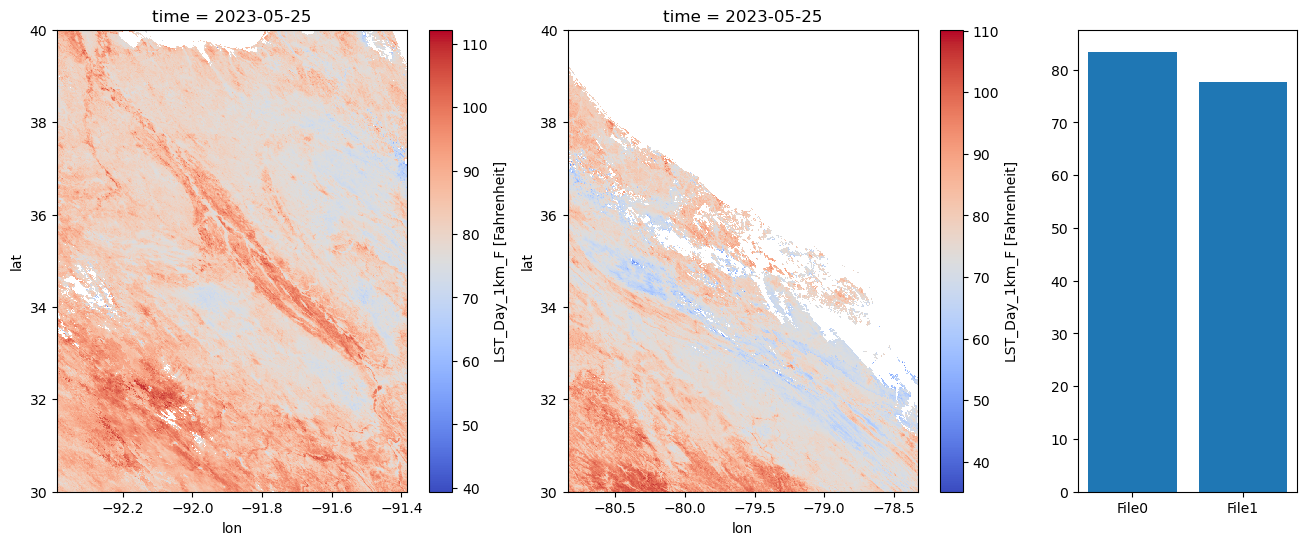

In [306]:
fig, axes = plt.subplots(ncols=3, gridspec_kw={'width_ratios':[.4,.4,.2]},
                         figsize=(16, 6))#,  sharey=True)

x0['LST_Day_1km_F'].plot(x='lon', y='lat', cmap='coolwarm', ax=axes[0],)  

x1['LST_Day_1km_F'].plot(x='lon', y='lat', cmap='coolwarm', ax=axes[1])

# Plot the means of both datasets
axes[2].bar(['File0','File1'],
            [x0['LST_Day_1km_F'].mean().values,
                x1['LST_Day_1km_F'].mean().values
             ], label='Mean Temp');


In [312]:
# xr.merge([x0, x1])#['LST_Day_1km_F'].mean().plot(ax=axes[2], label='Merged Mean Temp')
# Concatenate along the longitude dimension
combined_data_array = xr.concat([x0, x1], dim='file')

print(combined_data_array)

<xarray.Dataset> Size: 277MB
Dimensions:           (file: 2, time: 1, YDim:MODIS_Grid_8Day_1km_LST: 1200,
                       XDim:MODIS_Grid_8Day_1km_LST: 1200)
Coordinates:
  * time              (time) object 8B 1684972800000000000
    lat               (YDim:MODIS_Grid_8Day_1km_LST) float64 10kB 30.0 ... 40.0
    lon               (file, XDim:MODIS_Grid_8Day_1km_LST) float64 19kB -92.3...
Dimensions without coordinates: file, YDim:MODIS_Grid_8Day_1km_LST,
                                XDim:MODIS_Grid_8Day_1km_LST
Data variables: (12/14)
    LST_Day_1km       (file, time, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 23MB ...
    QC_Day            (file, time, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 12MB ...
    Day_view_time     (file, time, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 23MB ...
    Day_view_angl     (file, time, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 23MB ...
 

In [315]:
help(combined_data_array.plot)

Help on DatasetPlotAccessor in module xarray.plot.accessor object:

class DatasetPlotAccessor(builtins.object)
 |  DatasetPlotAccessor(dataset: 'Dataset') -> 'None'
 |  
 |  Enables use of xarray.plot functions as attributes on a Dataset.
 |  For example, Dataset.plot.scatter
 |  
 |  Methods defined here:
 |  
 |  __call__(self, *args, **kwargs) -> 'NoReturn'
 |      Call self as a function.
 |  
 |  __init__(self, dataset: 'Dataset') -> 'None'
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  quiver(ds: 'Dataset', *args: 'Any', x: 'Hashable | None' = None, y: 'Hashable | None' = None, u: 'Hashable | None' = None, v: 'Hashable | None' = None, hue: 'Hashable | None' = None, hue_style: 'HueStyleOptions' = None, row: 'Hashable | None' = None, col: 'Hashable | None' = None, col_wrap: 'int | None' = None, ax: 'Axes | None' = None, figsize: 'Iterable[float] | None' = None, size: 'float | None' = None, aspect: 'AspectOptions' = None, sharex: 'bool' = True, share

> Combined array below cannot be plotted due to mismatch x-values

TypeError("Axes.hist() got multiple values for argument 'x'")

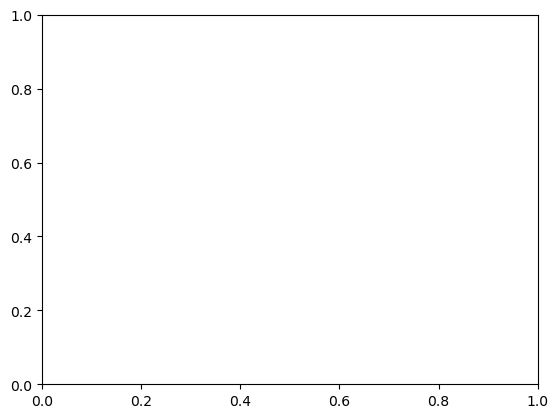

In [321]:
try:
    combined_data_array['LST_Day_1km_F'].plot(x='lon', y='lat', cmap='coolwarm')  
except Exception as e:
    display(e)


#### Comparing Rural vs Urban Duplicates

In [127]:
x0_rural = xr.open_dataset(grouped_duplicates['rural'][0]['.hdf_file'], engine='netcdf4')
x0_rural['LST_Day_1km'].shape

(1200, 1200)

In [129]:
import missingno

In [108]:
grouped_files.keys()

dict_keys([('rural', Timestamp('2023-05-25 00:00:00+0000', tz='UTC')), ('rural', Timestamp('2023-06-02 00:00:00+0000', tz='UTC')), ('rural', Timestamp('2023-06-10 00:00:00+0000', tz='UTC')), ('rural', Timestamp('2023-06-18 00:00:00+0000', tz='UTC')), ('rural', Timestamp('2023-06-26 00:00:00+0000', tz='UTC')), ('rural', Timestamp('2023-07-04 00:00:00+0000', tz='UTC')), ('rural', Timestamp('2023-07-12 00:00:00+0000', tz='UTC')), ('rural', Timestamp('2023-07-20 00:00:00+0000', tz='UTC')), ('rural', Timestamp('2023-07-28 00:00:00+0000', tz='UTC')), ('rural', Timestamp('2023-08-05 00:00:00+0000', tz='UTC')), ('rural', Timestamp('2023-08-13 00:00:00+0000', tz='UTC')), ('rural', Timestamp('2023-08-21 00:00:00+0000', tz='UTC')), ('rural', Timestamp('2023-08-29 00:00:00+0000', tz='UTC')), ('urban', Timestamp('2023-05-25 00:00:00+0000', tz='UTC')), ('urban', Timestamp('2023-06-02 00:00:00+0000', tz='UTC')), ('urban', Timestamp('2023-06-10 00:00:00+0000', tz='UTC')), ('urban', Timestamp('2023-06-

<Axes: >

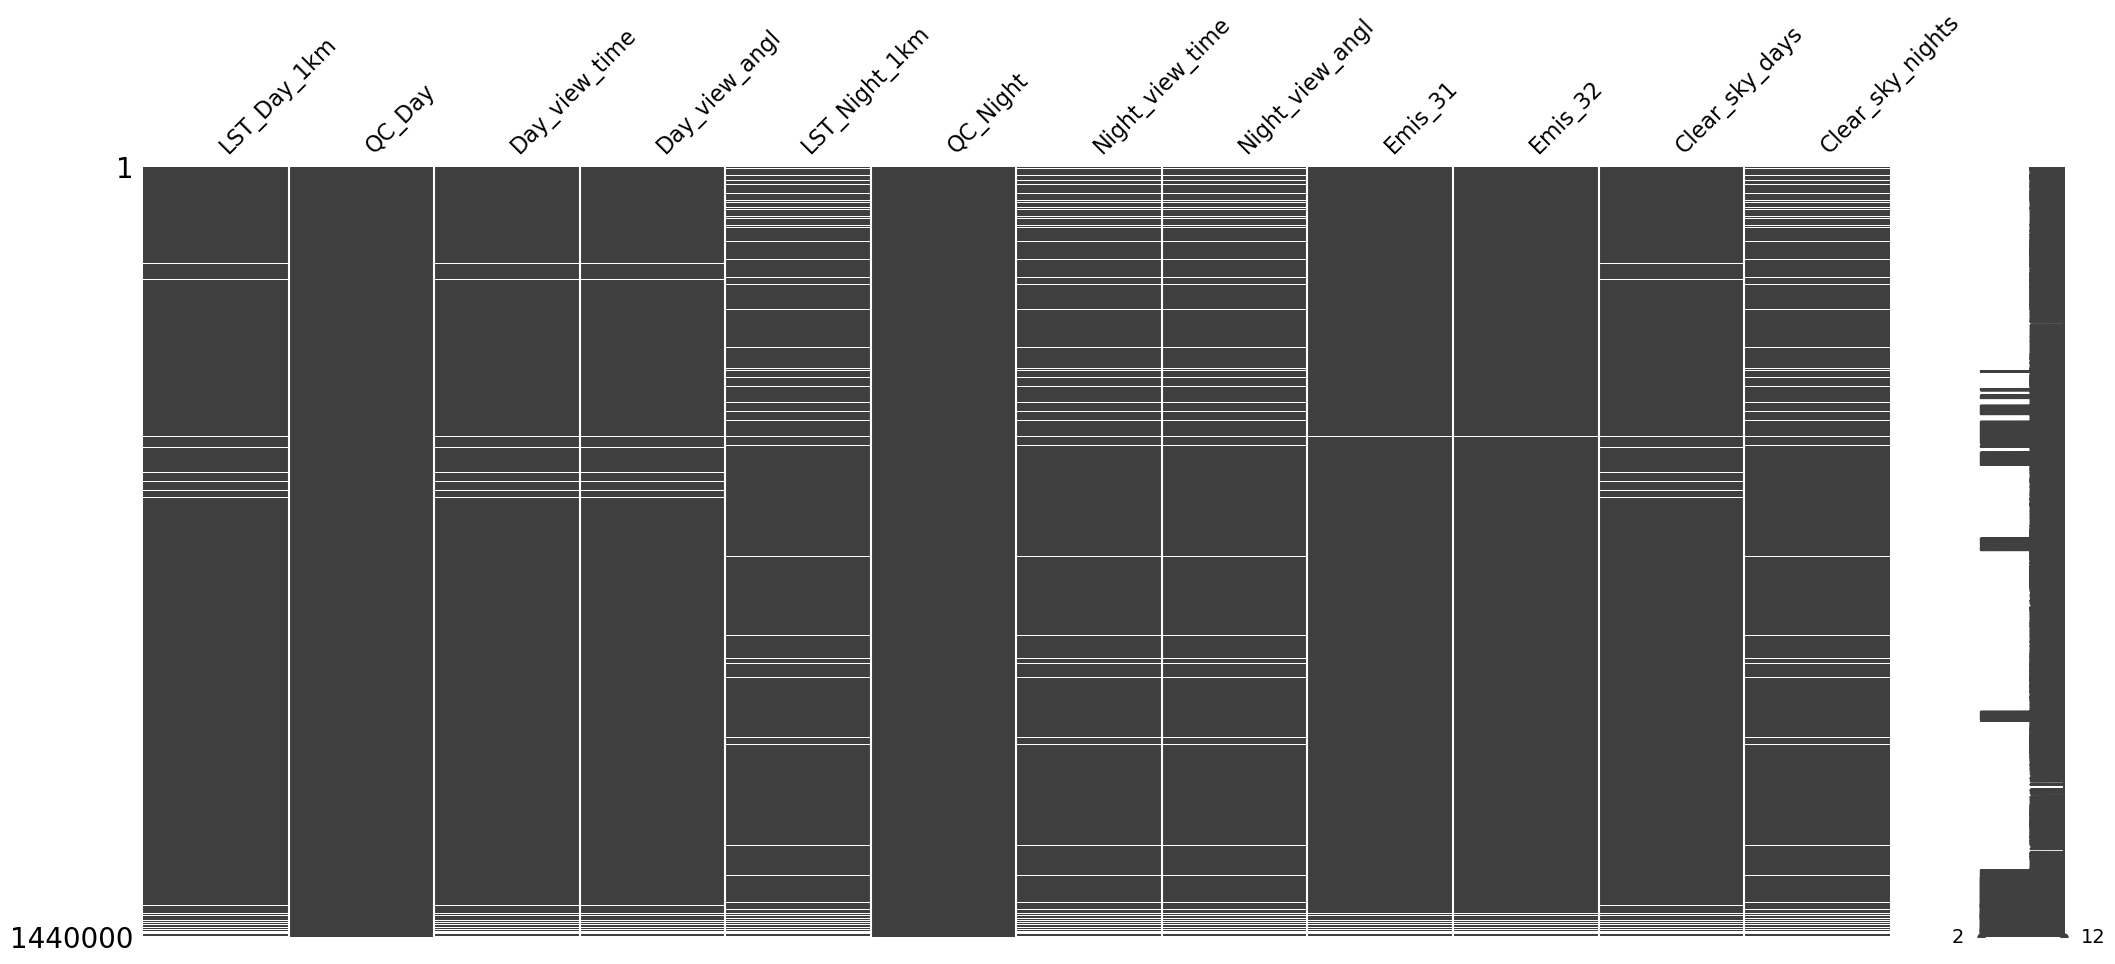

<Figure size 640x480 with 0 Axes>

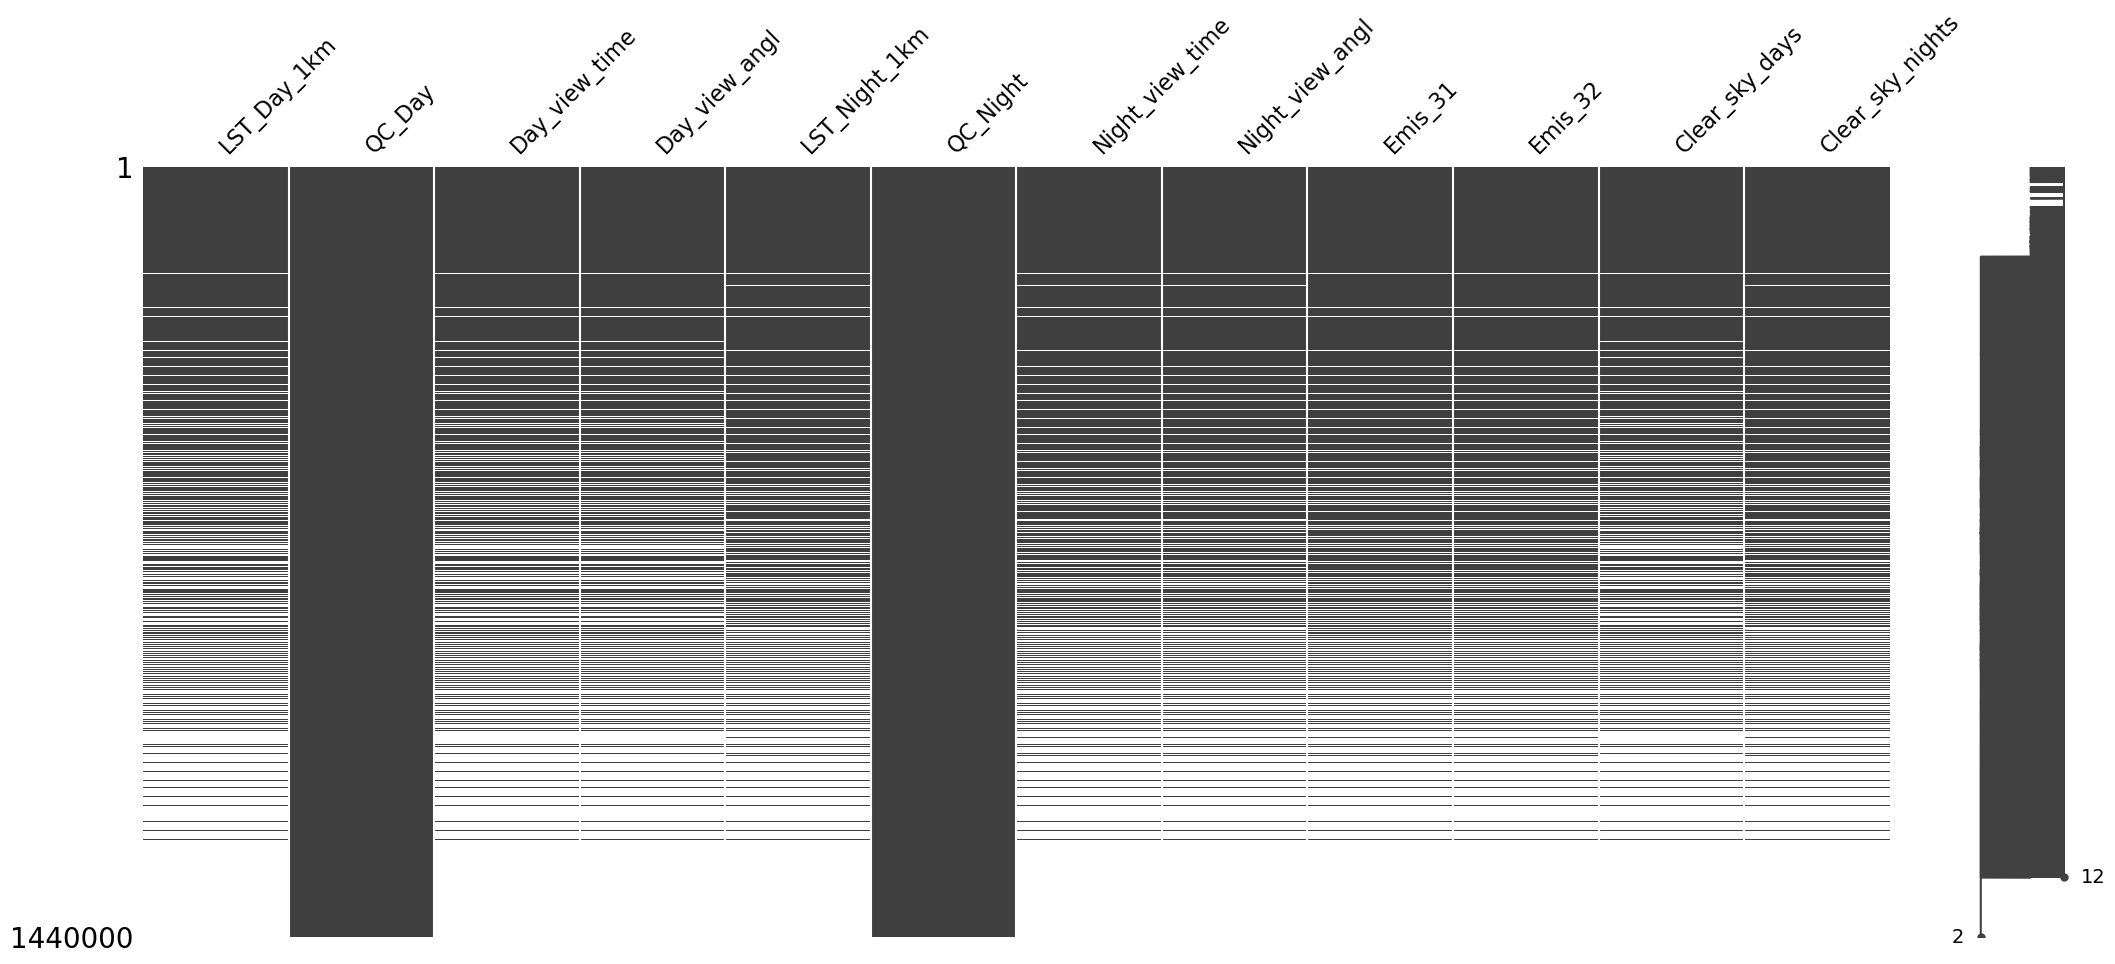

In [131]:
missingno.matrix(x0.to_dataframe())
plt.figure()
missingno.matrix(x1.to_dataframe())

#### Assigning Coordinates Based on XML Data

In [152]:
coordinate_cols

['Spatial_Coordinates__SW',
 'Spatial_Coordinates__SE',
 'Spatial_Coordinates__NW',
 'Spatial_Coordinates__NE']

In [ ]:
def save_coordinates(ds, lat1,lat2, lon1, lon2):
    ## Define the latitude and longitude ranges based on the MODIS tile
    latitudes = np.linspace(lat1, lat2, ds.sizes['YDim:MODIS_Grid_8Day_1km_LST'])
    longitudes = np.linspace(lon1, lon2, ds.sizes['XDim:MODIS_Grid_8Day_1km_LST'])

    # Add latitude and longitude as coordinates
    ds = ds.assign_coords(lat=('YDim:MODIS_Grid_8Day_1km_LST', latitudes))
    ds = ds.assign_coords(lon=('XDim:MODIS_Grid_8Day_1km_LST', longitudes))
    
    return ds



### Checking to make sure Coordinates are on land

To determine whether your coordinates are over land or sea, you can use a geographic information system (GIS) library like `geopandas` along with a shapefile that contains land and sea boundaries. One such dataset is the Natural Earth dataset, which provides vector data for land and water boundaries.

Here’s how you can achieve this using Python:

1. **Install the required libraries:**
   - `geopandas`: For handling geographic data.
   - `shapely`: For geometric operations.

2. **Download the Natural Earth dataset:**
   - You can download the Natural Earth land polygons dataset from [Natural Earth](https://www.naturalearthdata.com/downloads/110m-physical-vectors/).

3. **Load the shapefile and check the coordinates:**

In [ ]:
# Load the Natural Earth land polygons shapefile (see above link to download data)
land_shapefile = "./data/110m_physical/ne_110m_land.shp" #"path/to/ne_110m_land.shp"
land = gpd.read_file(land_shapefile, engine='fiona')
land.head(3)

In [ ]:
# Function to check if a coordinate is over land
def is_land(lat, lon, land_gdf):
    point = Point(lon, lat)
    return any(land_gdf.contains(point))

In [ ]:

# Function to generate sample points within a bounding box
def generate_sample_points(sw, ne, num_points=10):
    latitudes = [sw[0] + i * (ne[0] - sw[0]) / (num_points - 1) for i in range(num_points)]
    longitudes = [sw[1] + i * (ne[1] - sw[1]) / (num_points - 1) for i in range(num_points)]
    return [(lat, lon) for lat in latitudes for lon in longitudes]

Looping through all the regions and bounds within our coordinates to identify how many points are over land and sea (should all be over land)

In [ ]:
# # Define your coordinates
# coordinates = {
#     'urban': {"SW": [29.5, -95.5], "NE": [30.0, -95.0]},
#     'rural': {"SW": [30.5, -96.5], "NE": [31.0, -96.0]},
# }

# Check if any coordinates within the bounding boxes are over sea
# coordinates variable comes from: data_params['coordinates']
for region, bounds in coordinates.items():
    sw = bounds['SW']
    ne = bounds['NE']
    
    # Generate sample points within the bounding box
    sample_points = generate_sample_points(sw, ne, num_points=100)
    
    sea_points = []
    land_points = []
    for lat, lon in sample_points:
        if is_land(lat, lon, land):
            land_points.append((lat, lon))
        else:
            sea_points.append((lat, lon))
    
    if sea_points:
        print(f"Region: {region} has points over the sea.")
    else:
        print(f"Region: {region} is entirely over land.")
    
    
    # Print details
    print(f"Number of land points: {len(land_points)}")
    print(f"Number of sea points: {len(sea_points)}")

In [ ]:
files_df.head()

In [ ]:
USE_DICT= True
file_list_dict = files_df.groupby('region')['.hdf_file'].apply(list).to_dict()

shape_list = []

if USE_DICT:
    # Loop to load all files
    dataset_dict = {'urban':[],
                    'rural':[]}
else:
    dataset_list = []

for group, file_list in file_list_dict.items():
    for fpath in file_list:
        # Open the HDF5 file
    
        dataset = xr.open_dataset(fpath, engine='netcdf4')
    
        # Save the group as an attribute
        dataset = dataset.expand_dims(group=[group])
        
        shape_list.append([group, dataset['LST_Day_1km'].shape])
        # dataset.attrs['group'] = group
        
        
        
        if USE_DICT:
            dataset_dict[group].append(dataset)
        else:
            dataset_list.append(dataset)
        

if USE_DICT:
    print(f'- Using dictionary')
    # Combine all the datasets into a single dataset
    ds_rural = xr.concat(dataset_dict['rural'], dim='time')
    ds_urban = xr.concat(dataset_dict['urban'], dim='time')
    
    # Combined dataset (added back)
    ds = xr.concat([ds_rural, ds_urban], dim='time')

else:
    print(f'- Using list')
    ds = xr.concat(dataset_list, dim='time')

print(ds)

In [ ]:
## CONVERT THE TEMPERATURE FROM KELVIN TO CELSIUS AND FAHRENHEIT
def convert_temp_in_array(dataset, verbose=True):
    
    # Convert LST from Kelvin to Celsius
    lst_celsius = dataset['LST_Day_1km']-273.15#* 0.02 - 273.15

    # Convert LST from Celsius to Fahrenheit
    lst_fahrenheit = (lst_celsius * 9 / 5) + 32

    # Add these new variables to the dataset
    dataset['LST_Day_1km_C'] = lst_celsius #(('time', 'YDim:MODIS_Grid_8Day_1km_LST', 'XDim:MODIS_Grid_8Day_1km_LST'), lst_celsius.data)
    # Add attributes to the new variables
    dataset['LST_Day_1km_C'].attrs['units'] = 'Celsius'
    dataset['LST_Day_1km_C'].attrs['description'] = 'Land Surface Temperature in Celsius'


    # Add these new variables to the dataset
    dataset['LST_Day_1km_F'] = lst_fahrenheit #(('time', 'YDim:MODIS_Grid_8Day_1km_LST', 'XDim:MODIS_Grid_8Day_1km_LST'), lst_fahrenheit.data)
    # Add attributes to the new variables
    dataset['LST_Day_1km_F'].attrs['units'] = 'Fahrenheit'
    dataset['LST_Day_1km_F'].attrs['description'] = 'Land Surface Temperature in Fahrenheit'

    if verbose:
        # Inspect the updated dataset
        print("Updated Dataset:\n", dataset)

    return dataset


ds_rural = convert_temp_in_array(ds_rural)
ds_urban = convert_temp_in_array(ds_urban)

In [ ]:
from pprint import pprint
coordinates = data_params['coordinates']
time = data_params['time']

pprint(f"{coordinates=}")
pprint(f"{time=}")

In [ ]:
lat_lons = {}

for group, bounds in coordinates.items():
    
    # Create a bounding box
    latitutes = [bounds['SW'][0], bounds['NE'][0]]
    longitudes = [bounds['SW'][1], bounds['NE'][1]]
    lat_lons[group] = {'lat': latitutes, 'lon': longitudes}
    
    # bbox = box(*bounds['SW'], *bounds['NE'])
    # lat_lons[group]['box'] = bbox
    
    # x_array = np.linspace(*longitudes, ds.sel(group=group).sizes['XDim:MODIS_Grid_8Day_1km_LST'])
    # y_array = np.linspace(*latitutes, ds.sel(group=group).sizes['YDim:MODIS_Grid_8Day_1km_LST'])
    
    # lat_lons[group]['x'] = x_array
    # lat_lons[group]['y'] = y_array
    
lat_lons

In [ ]:
# def save_coordinates(ds, lat1,lat2, lon1, lon2):
#     ## Define the latitude and longitude ranges based on the MODIS tile
#     latitudes = np.linspace(lat1, lat2, ds.sizes['YDim:MODIS_Grid_8Day_1km_LST'])
#     longitudes = np.linspace(lon1, lon2, ds.sizes['XDim:MODIS_Grid_8Day_1km_LST'])

#     # Add latitude and longitude as coordinates
#     ds = ds.assign_coords(lat=('YDim:MODIS_Grid_8Day_1km_LST', latitudes))
#     ds = ds.assign_coords(lon=('XDim:MODIS_Grid_8Day_1km_LST', longitudes))
    
#     return ds

ds_rural = save_coordinates(ds_rural, *lat_lons['rural']['lat'], *lat_lons['rural']['lon'])
ds_urban = save_coordinates(ds_urban, *lat_lons['urban']['lat'], *lat_lons['urban']['lon'])

In [ ]:
# Checking that cordinates are different
# ds_rural.keys()

In [ ]:
# Checking that cordinates are different
ds_rural.coords

In [ ]:
# Getting min/max of rural region
lats_rural = ds_rural.coords['lat'].values
lons_rural = ds_rural.coords['lon'].values

print("- For rural region")
print(f"{lats_rural.min()=}, {lats_rural.max()=}")
print(f"{lons_rural.min()=}, {lons_rural.max()=}")

In [ ]:
# Getting min/max of urban region
lats_urban = ds_urban.coords['lat'].values
lons_urban = ds_urban.coords['lon'].values

print("- For urban region")
print(f"{lats_urban.min()=}, {lats_urban.max()=}")
print(f"{lons_urban.min()=}, {lons_urban.max()=}")

In [ ]:
print(f"{lats_rural.min() == lats_urban.min()}")
print(f"{lats_rural.max() == lats_urban.max()}")
print(f"{lons_rural.min() == lons_urban.min()}")
print(f"{lons_rural.max() == lons_urban.max()}")

In [ ]:
### Testing what happens to lat and lon when we concatenate

# Merge datasets while preserving unique coordinates
ds = ds_rural.combine_first(ds_urban)

# ds = xr.concat([ds_rural, ds_urban], dim='time')
print(ds)

In [ ]:
## Get lat lon from the combined dataset
# Getting min/max of rural region
lats_rural = ds.sel(group='rural').coords['lat'].values
lons_rural = ds.sel(group='rural').coords['lon'].values

print("- For rural region")
print(f"{lats_rural.min()=}, {lats_rural.max()=}")
print(f"{lons_rural.min()=}, {lons_rural.max()=}")


# Getting min/max of urban region
lats_urban = ds.sel(group='urban').coords['lat'].values
lons_urban = ds.sel(group='urban').coords['lon'].values

print("- For urban region")
print(f"{lats_urban.min()=}, {lats_urban.max()=}")
print(f"{lons_urban.min()=}, {lons_urban.max()=}")


print('- Do the min/max values match?')
print(f"{lats_rural.min() == lats_urban.min()}")
print(f"{lats_rural.max() == lats_urban.max()}")
print(f"{lons_rural.min() == lons_urban.min()}")
print(f"{lons_rural.max() == lons_urban.max()}")

>- The lat/lon do NOT match when separate x-arrays, but they match once concatenated the datasets.
>- 🤔 **Could this be due to coordinates being a coord instead of a dimension?**

### Chris creating loop to see percent of null values in each col

In [ ]:
i_sel = 1
df_rural = ds_rural['LST_Day_1km'].isel(time=i_sel).to_dataframe().reset_index()
df_urban = ds_urban['LST_Day_1km'].isel(time=i_sel).to_dataframe().reset_index()

In [ ]:
def check_for_nans(df):
    # list of column names from the dataset
    ds_variable_columns = list(df.keys())
    # empty list that we will store dictionaries in
    all_time = []
    # empty list that we will store dataframes in
    all_time_df = []

    for i in range(df.sizes['time']):
        test_dict = {}
        for col in ds_variable_columns:
            loop_df = df[col].isel(time=i).to_dataframe().reset_index()
            temp_dict = {'Mean' : round(loop_df[col].isna().mean(), 4), 
                        'Sum': loop_df[col].isna().sum()}
            test_dict[col] = temp_dict
        all_time.append(test_dict)

    # transforming the dictionaries we created into dataframes and storing them into a list
    for i, test_dict in enumerate(all_time):
        temp_df = pd.DataFrame(test_dict)
        temp_df = temp_df.loc['Mean']
        temp_df.name = f"Time_{i+1}"
        all_time_df.append(temp_df)

    return pd.concat(all_time_df, axis=1)

In [ ]:
i = 0
loop_df = ds_urban['LST_Day_1km_F'].isel(time=i).to_dataframe().reset_index()
loop_df

In [ ]:
# missingno.matrix(loop_df)
sns.heatmap(loop_df.isna())

In [ ]:
i_sel = 0
df_rural = ds_rural.isel(time=i_sel).to_dataframe().reset_index()
df_urban = ds_urban.isel(time=i_sel).to_dataframe().reset_index()

df = pd.concat([df_rural, df_urban])
df

In [ ]:
# all values
df['QC_Day'].value_counts(dropna=False).sort_index()

In [ ]:
# QC for all rows that have null values
df[df['LST_Night_1km'].isna()]['QC_Day'].value_counts(dropna=False).sort_index()

In [ ]:
# QC for all rows that have no null values
df[df['LST_Night_1km'].notnull()]['QC_Day'].value_counts(dropna=False)

In [ ]:
# checking QC control versus null values
df['is_null'] = df['LST_Day_1km'].isna()
# creating new col that identifies if the value of QC_Day is 2 or 3
df['is_2_or_3'] = df['QC_Day'].isin([2.0, 3.0])
# confirming that all null values in LST_Day_1km are associated with either 2 or 3 in teh QC_Day col
(df['is_null'] == df['is_2_or_3']).all()

In [ ]:
df.groupby('is_null', as_index=False)['QC_Day'].unique()#.value_counts(dropna=False)

In [ ]:
sns.heatmap(df_urban.isna())

### QC_Day == 2 or 3 indicates Null values. We need to figure out why, and what those numbers actually mean

The Quality Control (QC) flags in MODIS data, specifically QC_Day, have several bit flags that indicate different aspects of the data quality. According to the MODIS user guide, the meanings of QC_Day values 2 and 3 are as follows:

- **QC_Day = 2**: This indicates that the land surface temperature (LST) was not produced due to cloud effects.
- **QC_Day = 3**: This indicates that the LST was not produced primarily due to reasons other than clouds, such as an ocean grid or a grid not covered by all processed granules .

These values can help you understand why certain data points might be missing or marked as NaN (Not a Number). If your dataset has a high number of these QC_Day values, it suggests that a significant portion of the area was either cloud-covered or had other issues preventing LST measurement. This could explain why one dataset has significantly more NaN values compared to another. (From ChatGPT)

In [ ]:
# checking QC control versus null values
df['is_null_night'] = df['LST_Night_1km'].isna()
# creating new col that identifies if the value of QC_Day is 2 or 3
df['is_2_or_3_night'] = df['QC_Night'].isin([2.0, 3.0])
# confirming that all null values in LST_Day_1km are associated with either 2 or 3 in teh QC_Day col
(df['is_null_night'] == df['is_2_or_3_night']).all()

In [ ]:
urban_nans_df = check_for_nans(ds_urban)
rural_nans_df = check_for_nans(ds_rural)

In [ ]:
urban_nans_df.style.background_gradient(vmin=0, vmax=0.5)

In [ ]:
rural_nans_df.style.background_gradient(vmin=0, vmax=0.5)

### Investigating null values

In [ ]:
urban_nans_df.style.bar()

In [ ]:
ax = urban_nans_df.T.plot(subplots=True, figsize=(10,8))
# ax.legend(bbox_to_anchor=[1, 1]);

In [ ]:
ds_urban.data_vars

In [ ]:
# Plot using Plotly Express
fig = px.scatter_mapbox(df.sample(n=10_000), lat="lat", lon="lon", color="LST_Day_1km",
                        # color_continuous_scale="Viridis", 
                        mapbox_style="carto-positron",
                        title="Land Surface Temperature in Celsius",
                        height=600, hover_data=["QC_Day", "Clear_sky_days"])


fig.update_traces(marker=dict(size=3))

fig.show()

In [ ]:
df['Clear_sky_days'].value_counts(dropna=False)

In [ ]:
df.groupby("group").mean().reset_index()

# sns.barplot(data=df, x='group', y='LST_Day_1km')